# Starsim tutorial

#### A step by step tutorial on using starsim

## What is starsim?
Starsim is a tool to simulate photometry and spectroscopy of a spotted rotating star. It has two main modes:
* **Forward mode**: From a custom spot map and stellar parameters, allows simulating photometry (light curves at different bandpass) and spectroscopy (RV, FWHM, BIS, contrast, CRX) at the desired times of observation.
* **Inverse mode**: From multiple (or single) time series of different observables and instruments, derive the spot map and the stellar parameters that best reproduce the input parameters.

## 1.- Installation

**WARNING**: Before installation, be aware that starsim can be only executed using Python 3.X, so make sure it is your default version. Otherwise, you can create a new enviroment with [anaconda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) or alternatively, in the following steps use `pip3` instead of `pip` and run any script with `python3 script.py` instead of `python script.py`.

Starsim can be downloaded from github, and installed using pip. Simply run:
```
git clone https://github.com/dbarochlopez/starsim.git
cd starsim
pip install .
```
Now starsim is installed and can be imported from any location.

## 2.-Downloading models
The main engine of starsim is based on synthetic spectra to generate the surface grid. In order to work, starsim needs two types of models, high-resolution models and intensity models, both based on the stellar atmosphere code PHOENIX ([Allard & Hauschildt 1995](https://ui.adsabs.harvard.edu/abs/1995ApJ...445..433A/abstract)) computed by [Husser et al. (2013)](https://www.aanda.org/articles/aa/full_html/2013/05/aa19058-12/aa19058-12.html#R1).

You can download them from https://www.ice.csic.es/owncloud/s/7kRTAJqKHxeHB3w, and replace the _starsim/models_ folder with the downloaded folder. The downloaded models contains temperatures from 2300K to 5500K, and surface gravities from 3.5 to 6.0. If a wider grid of temperatures and/or surface gravities are needed, the high resolution models can be found in http://phoenix.astro.physik.uni-goettingen.de/data/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/ (store them in models/Phoenix) and the intensity models in http://phoenix.astro.physik.uni-goettingen.de/data/SpecIntFITS/PHOENIX-ACES-AGSS-COND-SPECINT-2011/Z-0.0/ (store them in models/Phoenix_mu). **IMPORTANT**: if you download a new high-resolution model to models/Phoenix, the corresponding intensity model must be downloaded to models/Phoenix_mu, and vice versa. In case a model is missing, starsim will let you know.

Additionaly, the folder _starsim/models/filters_ contains some files with the bandpass of different instruments (TESS, Kepler, etc.). If you want to use different filters, you can create your own file, or download [here](http://svo2.cab.inta-csic.es/svo/theory/fps3/) the bandpass of the desired instrument.

## 3.- Setting up the configuration files

The definition of the stellar parameters, the spot map, and other options is made through two main files in the _starsim_ folder: starsim.conf and spotmap.dat.

* **starsim.conf**: used to set the stellar parameters and different modes and options of the simulation. The file is intended to be self-explanatory.
* **spotmap.dat**: used to define the spots appearence, lifetime, position, and radius. Each row correspond to a different spot. There are 14 columns. The first seven columns are: 1-Appearence time, 2-Lifetime, 3-Colatitude, 4-longitude (at the ref. time set in starsim.conf) 5,6,7-Coefficients determining the evolution of the radius of the spot, the behaviour depends on the _spots_evo_law_ set in starsim.conf (_spots_evo_law_=constant will only use column 5, and the radii will be constant. _spots_evo_law_=linear will use columns 5 and 6, and the radii will evolve from the value in column 5 to the value in column 6. More evolution laws will be added in the future. Columns 8 to 14  are only used in the inversion mode. They are related to the parameter 7 columns to the left, and are flags indicating if the parameter of the spot will be fixed (0) or optimized (1). E.g., column 9 of row 3 set to 1 means that the lifetime (column 2) of spot 3 (row 3) will be optimized.

## 4.- Starting the program

starsim can be executed from your terminal or through a python script. First, you have to import the starsim module and define an starsim object containing the info in starsim.conf and spotmap.dat.


In [1]:
import starsim

ss=starsim.StarSim(conf_file_path='starsim.conf')

The object ss now contains all the info in starsim.conf and spotmap.dat. After ss is defined, the options and spotmap can be accesed and modified without the need of rewriting the files, using ss.NAME_PARAM, with NAME_PARAM equal to the parameter name in starsim.conf. Lets check the current value of the rotation period and modify it to 2.5 days.

In [2]:
print(ss.rotation_period)
ss.rotation_period=2.5
print(ss.rotation_period)

10.0
2.5


Likewise, we can check and modify the spot map by using the command ss.spot_map. Lets check the colatitude of the first spot. The first index corresponds to the row, and the second index to the column. Remember that the first index in python is 0.

In [3]:
print('The first spot (index 0) is at a colatitude (index 2) of:')
print(ss.spot_map[0][2])

The first spot (index 0) is at a colatitude (index 2) of:
90.0


Before starting with the modeling, it is convenient to explain the two main modes of creating the surface grid available in starsim, which can be selected under the _simulation_mode_ keyword in starsim.conf.
* **Fast**: The stellar surface is simulated by a grid of photosphere elements with the same temperature and different limb darkening. Spots and faculae is treated as a single grid element, with properties defined by the coordinates of the central coordinate. This mode is relatively fast, but it is not recommended for spots with radii larger than 15-20 deg. The projected fillingfactor is not affected by this mode as it is analitically computed. 
* **Grid**: The stellar surface is simulated by a grid of different elements (spot, photosphere and facule), to which we assign the corresponding spectra and limb darkening. This option is a bit slower than the fast mode, but should be used for large spots, since different parts of the same spot have noticeabily different limb darkening/spectra. The size of the grid elements is controled by the ``n_grid_rings`` keyword. The width of a grid will be $180/(2\cdot n\_grid\_rings-1)$, in deg. For a decent computing time to resolution ratio, use a number of grids equal to $\max\{10,int(120/R)\}$, with R equal to the radius (in deg) of the smallest spot.

## 5.- Forward modeling

With the forward modeling, the user defines a spot map and a set of stellar parameters, and starsim simulates different observables at the required time stamps.

First, we import starsim and create the starsim object, as before. Then we create a simple spot map, with one 5 deg spot in the equator born at t=-1 and a liftime of 40 days.


In [4]:
import starsim 
import numpy as np
import matplotlib.pyplot as plt
#Create starsim objec, reads starsim.conf and spotmap.dat
ss=starsim.StarSim(conf_file_path='starsim.conf')
#Create a simple spot map. Only one spot. We initialize the map with all zeros.
ss.spot_map=np.zeros([1,14]) #One row, 14 columns. 14 columns are mandatory, the number of rows is the number of spots.
ss.spot_map[0][0]=-1 #appearence time in t=-1
ss.spot_map[0][1]=40 #lifetime of 40 days
ss.spot_map[0][2]=90 #colatitude 90 deg
ss.spot_map[0][4]=5 #spotsize 5 deg (using constant evo. law)

Then we execute the forward model, giving the times at which we want to simulate, and the observables we want, in this case the lightcurve, the radial velocities and the fwhm.

In [5]:
t_sampling=np.linspace(0,30,200) #sampling times

ss.compute_forward(observables=['lc','rv','fwhm'],t=t_sampling) #Available observables: (lc,rv,crx). bis, fwhm and contrast are aliases of rv.

The results are saved under the dictionary ss.results. Lets chek them with a couple of plots.

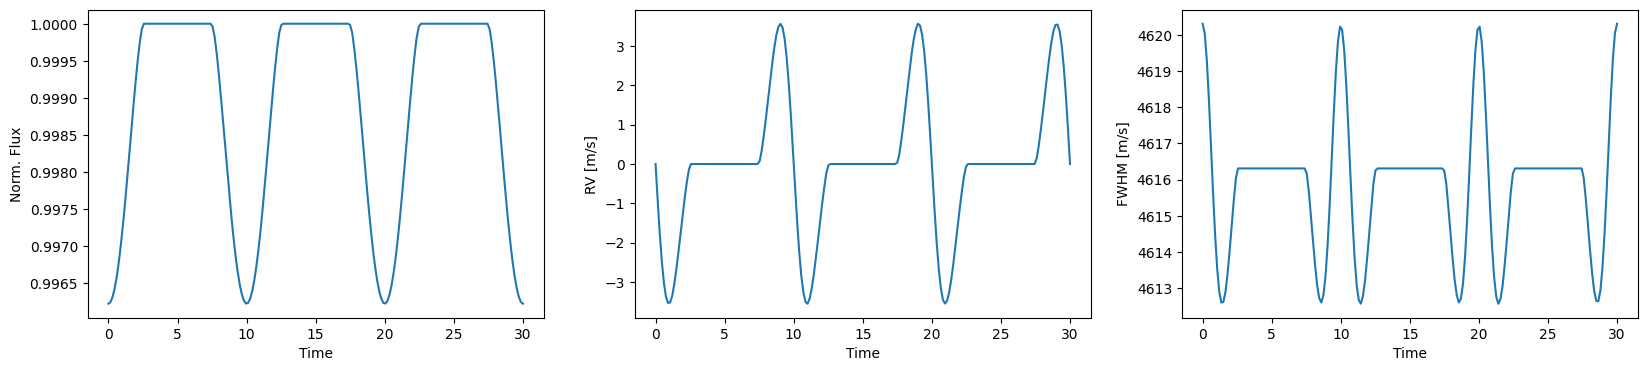

In [6]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot(t_sampling,ss.results['lc'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Norm. Flux')
ax[1].plot(t_sampling,ss.results['rv'])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('RV [m/s]')
ax[2].plot(t_sampling,ss.results['fwhm'])
ax[2].set_xlabel('Time')
ax[2].set_ylabel('FWHM [m/s]')
plt.show()

The plots can be automatically generated using the method `ss.plot_forward_results()`. The plot will be saved under the _starsim/plots_ folder. Lets show it with a little trick:

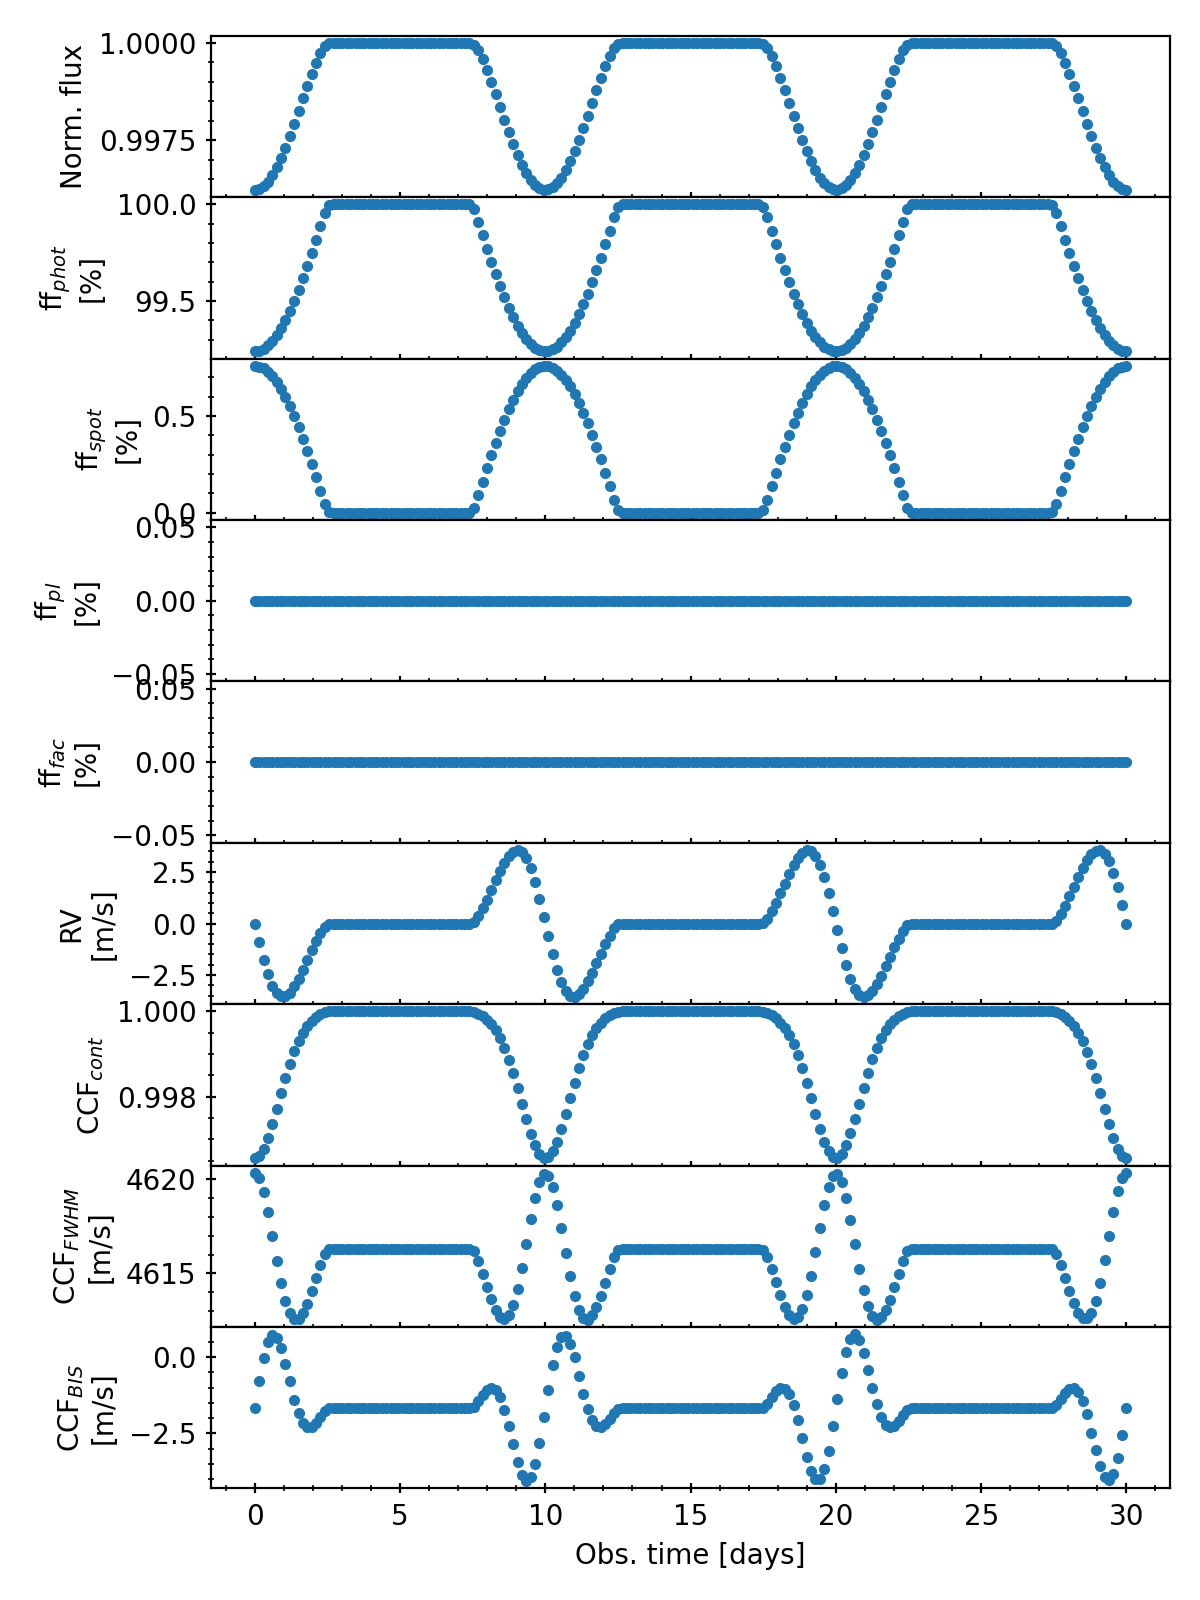

In [7]:
ss.plot_forward_results()
from IPython.display import Image  #trick to show a saved image
Image(filename='starsim/plots/forward_results.png',width=400) 

As you can se the figure contains subplots of more observable than the ones selected, such as the filling factors or all the CCF parameters. 

Note that even though we have set the rotation period to 2.5 with `ss.rotation_period=2.5`, the simulations show that the rotation period is still 10. Bear in mind that every time you define the ss object, it will read the starsim.conf file again and ignore all the changes made before, such as setting the period to 2.5.

### 5.1.- Introducing the chromatic indexs indicators

Starsim can also be tuned to work as an echelle spectrograph, computing the CCF parameters for each of the echelle orders containing a different wavelength range. This can be useful to simulate the dependence of the different parameters with the wavelength, which are called the chromatic indicators. To use this mode, one needs to generate a text file containing the number of order, the initial wavelength, and the final wavelength of a certain spectrograph, and store it in the folder _starsim/orders_CRX_. Lets run again the previous spot map adding the cromatic index and lot the results. Be aware that this mode will be much slower than with the 'lc' or 'rv' observables, since it has to repeat the simulation for each order (it should take ~1 minute). To simulate all the observables, you only need to set `observables=['lc','rv','crx']` as shown below:

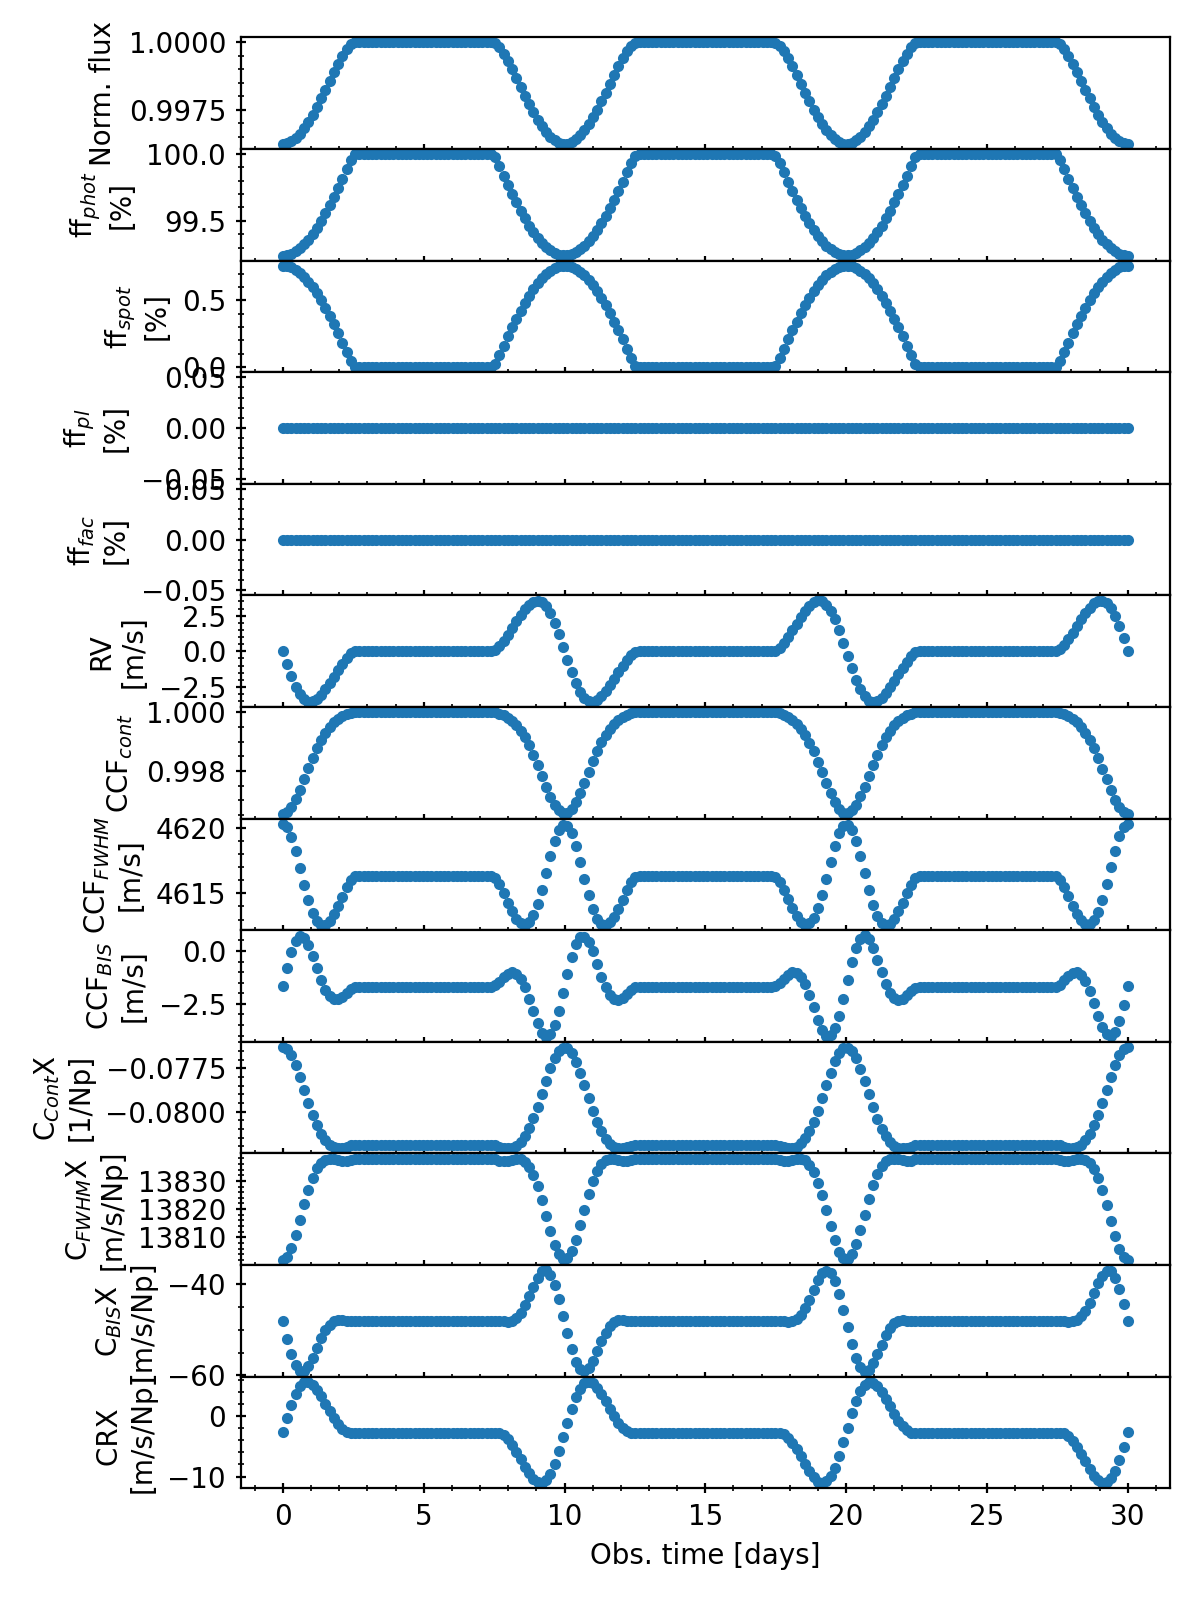

In [8]:
ss.compute_forward(observables=['lc','rv','crx'],t=t_sampling)
ss.plot_forward_results()
from IPython.display import Image  #trick to show a saved image
Image(filename='starsim/plots/forward_results.png',width=400) 

### 5.2.- Adding a planet

starsim can also simulate the effect of a transiting planet over the photometry, and all spectroscopic observables, including the rossiter-mclaughin effect and spot-crossing effects. To include a planet in the simulation, simply set _simulate_planet_ to 1 in starsim.conf, and run the forward model as before. We will reduce the simulated time to highlight the transit.

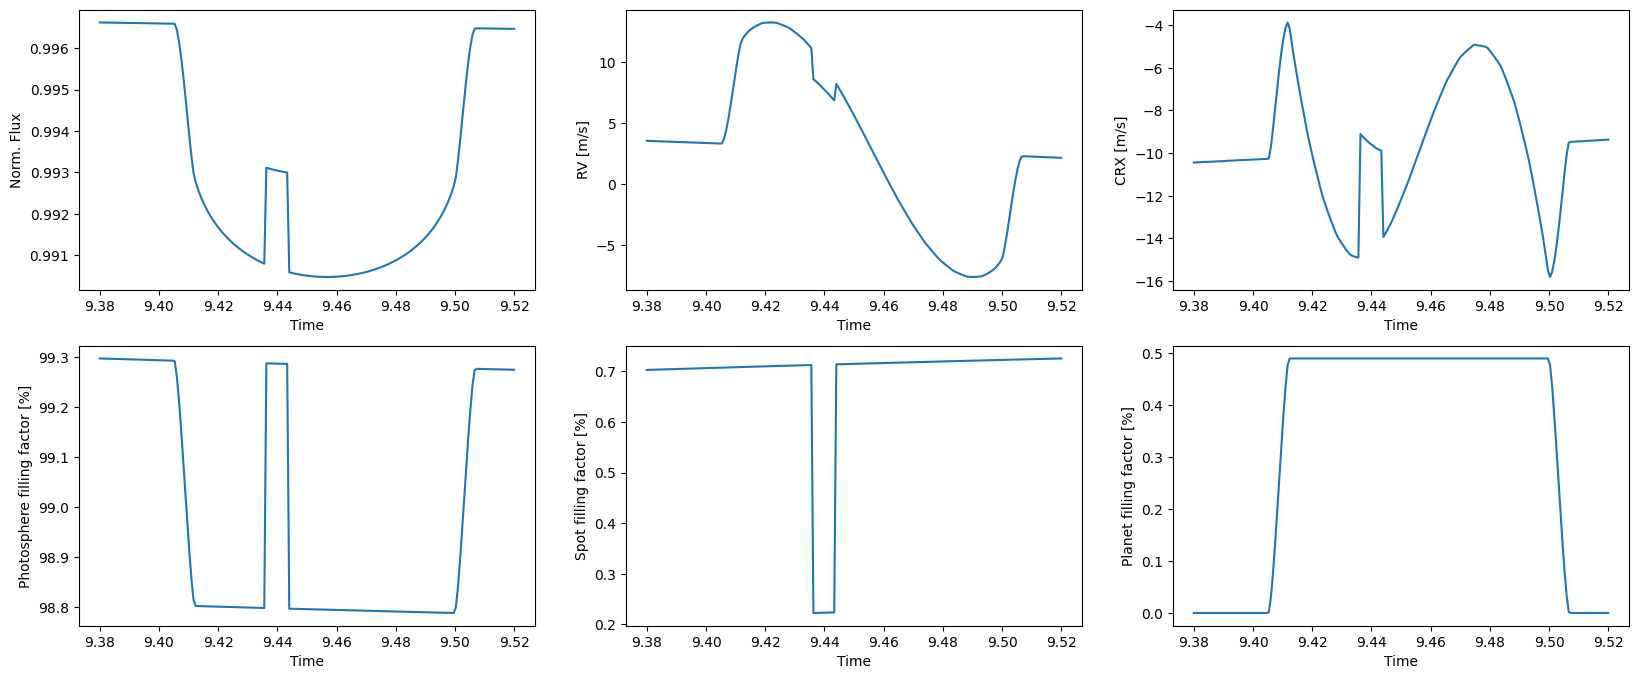

In [9]:
ss.simulate_planet=int(1) #Important to set it as an integer
t_sampling=np.linspace(9.38,9.52,200) #define the sampling time
ss.compute_forward(observables=['lc','rv','crx'],t=t_sampling) #simulate all observables

fig, ax = plt.subplots(2,3,figsize=(20,8))
ax[0,0].plot(t_sampling,ss.results['lc'])
ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Norm. Flux')
ax[0,1].plot(t_sampling,ss.results['rv'])
ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('RV [m/s]')
ax[0,2].plot(t_sampling,ss.results['crx'])
ax[0,2].set_xlabel('Time')
ax[0,2].set_ylabel('CRX [m/s]')
ax[1,0].plot(t_sampling,ss.results['ff_ph'])
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Photosphere filling factor [%]')
ax[1,1].plot(t_sampling,ss.results['ff_sp'])
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Spot filling factor [%]')
ax[1,2].plot(t_sampling,ss.results['ff_pl'])
ax[1,2].set_xlabel('Time')
ax[1,2].set_ylabel('Planet filling factor [%]')
plt.show()

As you can see in the plots, the transit stars at t=9.4, and there is a spot crossing event at t=9.44. This is reflected also in the filling factors.

Starsim not only simulates the drop in flux and the rossiter-Mclaughin effect, but also reproduces the effect over all other observables, such as the CRX. 

The spot crossing event produces a very sharp change in the observables, due to the lack of resolution in the overlapping between spot and planet. To avoid this, one should use the `precise` mode in starsim.cong with a very dense grid, but would be very time consuming to reproduce it here.

## 6.- Inverse mode

In the inverse model, the user provides any number of time-series of different observables, and starsim optimizes the spot map and/or the stellar parameters to match the observations. There are three main modes:

1. Compute N inversions with a given set of stellar parameters to obtain N spot maps. This is done with the method `best_maps, lnLs = ss.compute_inverseSA(N_inversions=N)` and returns the N best maps and log-likelihoods. Also returns the file `inversion_stats.npy` with the best maps and log-likelihoods. Uses the fast mode, so is not recommended for spots larger than ~20 deg.

2. Optimize the stellar parameters. Inside a user-defined range, starsim selects random stellar parameters, and for each set, computes the best spot map and the best likelihood. This method can be called with `ss.optimize_inversion_SA()` and as an output produces the file `inversion_MCMCSA_stats.npy` with the log-likehood, the stellar parameters and spot map of each step. Also recommended for spots larger than ~20deg.

3. Optimize stellar parameters and spot map simultaneously using an MCMC. This method treats the spot parameters as additional stellar parameters, and can be used in both fast and precise modes, so is recommended for stars with big spots or for cases with no more than 2-3 spots. It is executed with `ss.optimize_MCMC()`. The output consists of a plot with the MCMC chains, a corner plot with the results and a list with the optimized parameters and uncertainties. 

### 6.1.- Loading the time series

First of all let's create som dummy observables which we will invert. In this example we are going to use one RV curve and one light curve. To make it simpler, manually modify the `spotmap.dat` file to be:

0.0 40.0 90.0 30.0 5.0 0.0 0.0  0 0 1 1 1 0 0 

0.0 40.0 60.0 310.0 2.0 0.0 0.0  0 0 1 1 1 0 0

That is, two spots spot born at t=-1, with a lifetime of 40 days, at colatitudes of 90 and 60 deg, longitudes of 30 and 310 deg, and radii of 5 and 2 deg. The integers in the last 7 columns are used to fix (0) or optimize (1) the parameters of the first 7 columns. That is, here we will optimize the colatitude, longitude and spot size of both spots.

In [10]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
t_sampling=np.linspace(0,30,30) #sampling times
ss.compute_forward(observables=['lc','rv'],t=t_sampling) 

y_lc=ss.results['lc']
dy_lc=0.0001*np.ones(len(y_lc)) #Dummy errors
y_rv=ss.results['rv']
dy_rv=0.01*np.ones(len(y_rv)) #Dummy errors

Lets now load the data into starsim. It is done with the method `ss.load_data`, and it can read data from either a three-column text file using the argument filename, or from already defined python variables, as in this case.

In [11]:
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)


Make sure that you specify the correct wavelength range and filter that the instrument is using. In this case we are using the same values as the specified in starsim.conf to run the forward model before, but may be different in your case.
Also, additional options to fit the data is given. If desired, you can add to the data a jitter term and an offset (multiplicative for the lc, fwhm and contrast observables, additive fr the others). Also, you can fix these parameters or let starsim optimize them at each inversion. In this case we are going to fix the offset.

The loaded data can be accesed with `ss.data['INSTRUMENT_NAME']['OBSERVABLE_NAME']`

### 6.2.- Inversion

Let's now invert this data and obtain 4 spot_maps. This can be parallelized, so make sure to use a convinient number of CPUs in the N_cpus option in starsim.conf or through ss.N_cpus. Remember that according to the spotmap file, we are optimizing the colatitude, longitude and size of a single spot. 

The execution of this line of code may take several minutes, but in your terminal it should show a progress bar and detailed information of the status of each inversion, with info about the step number, the acceptance fraction and the current best log-likelihood. In starsim.conf there is an option `N_iters_SA` to control the number of steps in each inversion. The default value is 7000, but can be increased to obtain better results or decreased to obtain faster results.

In [12]:
best_maps, lnLs = ss.compute_inverseSA(N_inversions=4)

Computing 4 inversions of 2 spots each.

Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1553.45it/s]


 Step=735/7000; Acc_frac=1.0000; lnL=-inf

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Step=2114/7000; Acc_frac=1.0000; lnL=-inf

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Step=3321/7000; Acc_frac=1.0000; lnL=-inf

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Step=4037/7000; Acc_frac=1.0000; lnL=-inf

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Step=5711/7000; Acc_frac=1.0000; lnL=-inf

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Step=6365/7000; Acc_frac=1.0000; lnL=-inf

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The idea of repeating the inversion N times is to increase statistics, since in some cases the optimization may be trapped in a local maxima.
Once the inversion is finished, one can plot the resulting inverted time series with the funcion `ss.plot_inversion_results(best_maps,lnLs,Npoints=500)`, which plot the loaded data togther with the time series obtained by each inversion. The plots of the best spot maps at the desired time stamps are obtained with
`ss.plot_spot_map(best_maps,tref=[t1,t2,t3,...])`. The map of the active regions at each longitude and time is obtained with
`ss.plot_active_longitudes(best_maps,tini=t_sampling[0],tfin=t_sampling[-1],N_obs=200)`.

In [13]:
ss.plot_inversion_results(best_maps,lnLs,Npoints=500)
ss.plot_spot_map(best_maps,tref=[10,11])
ss.plot_active_longitudes(best_maps,tini=t_sampling[0],tfin=t_sampling[-1],N_obs=200)

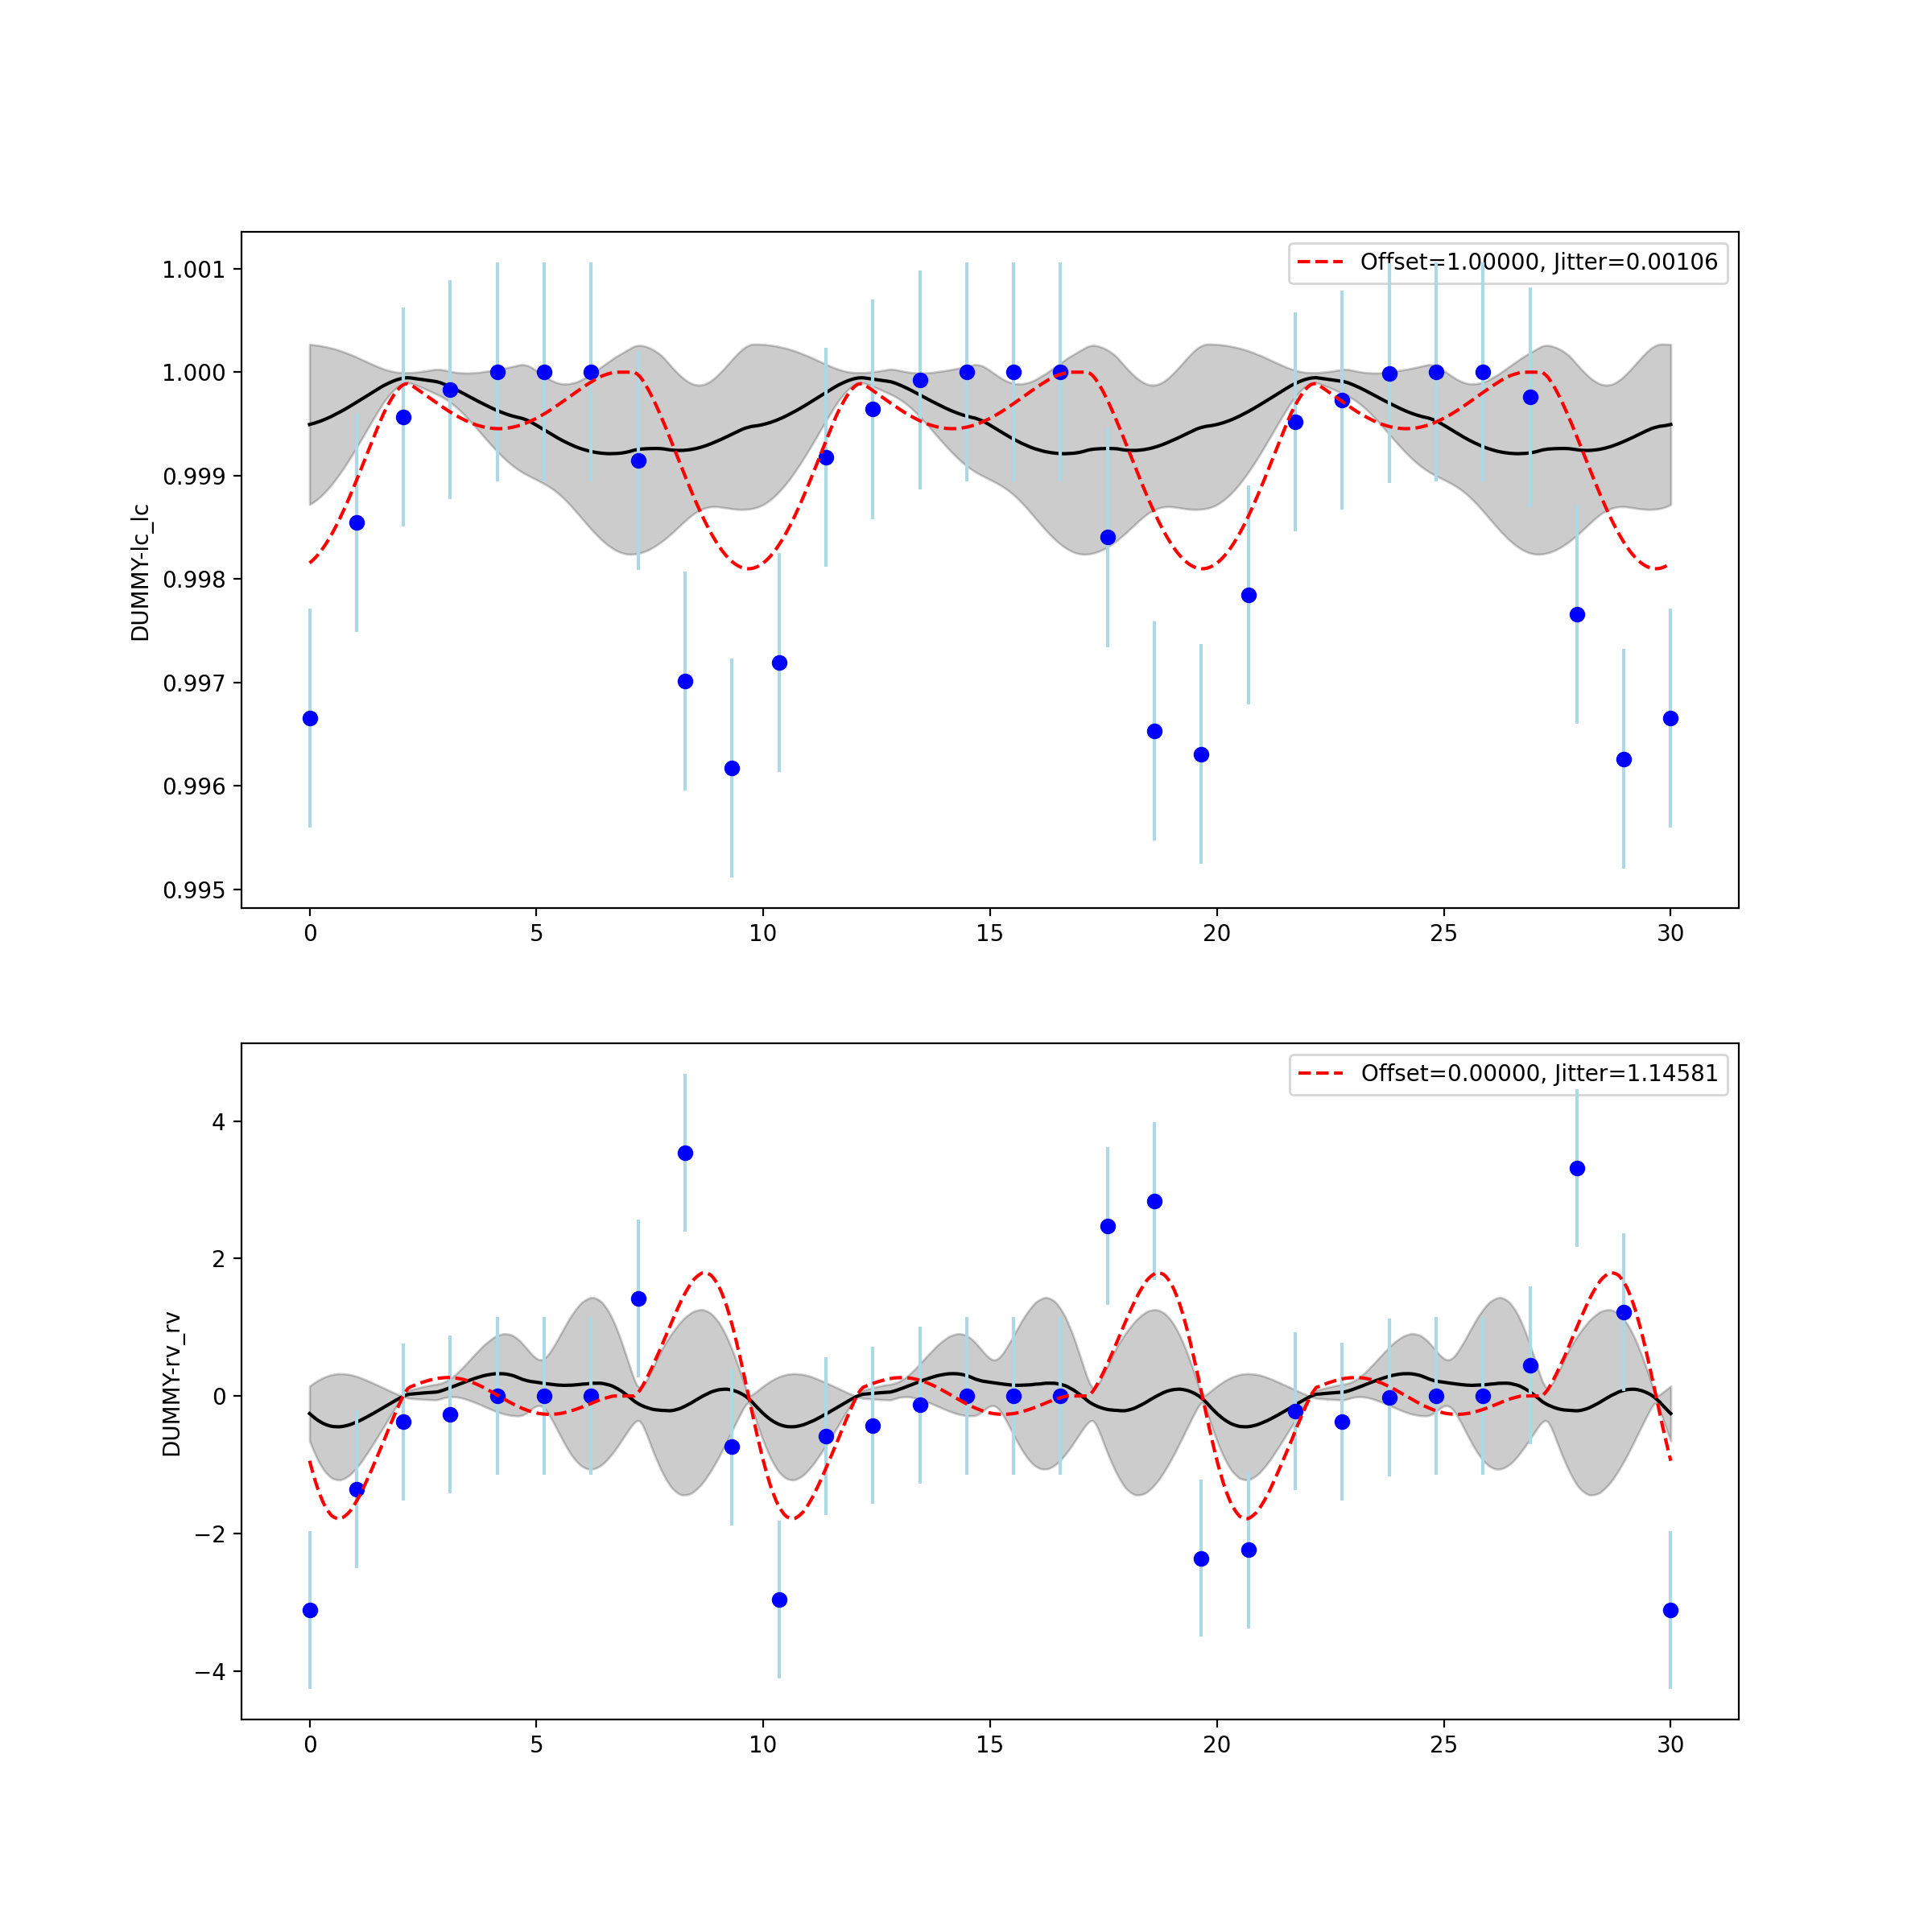

In [14]:
Image(filename='starsim/plots/inversion_timeseries_result.png',width=600) 

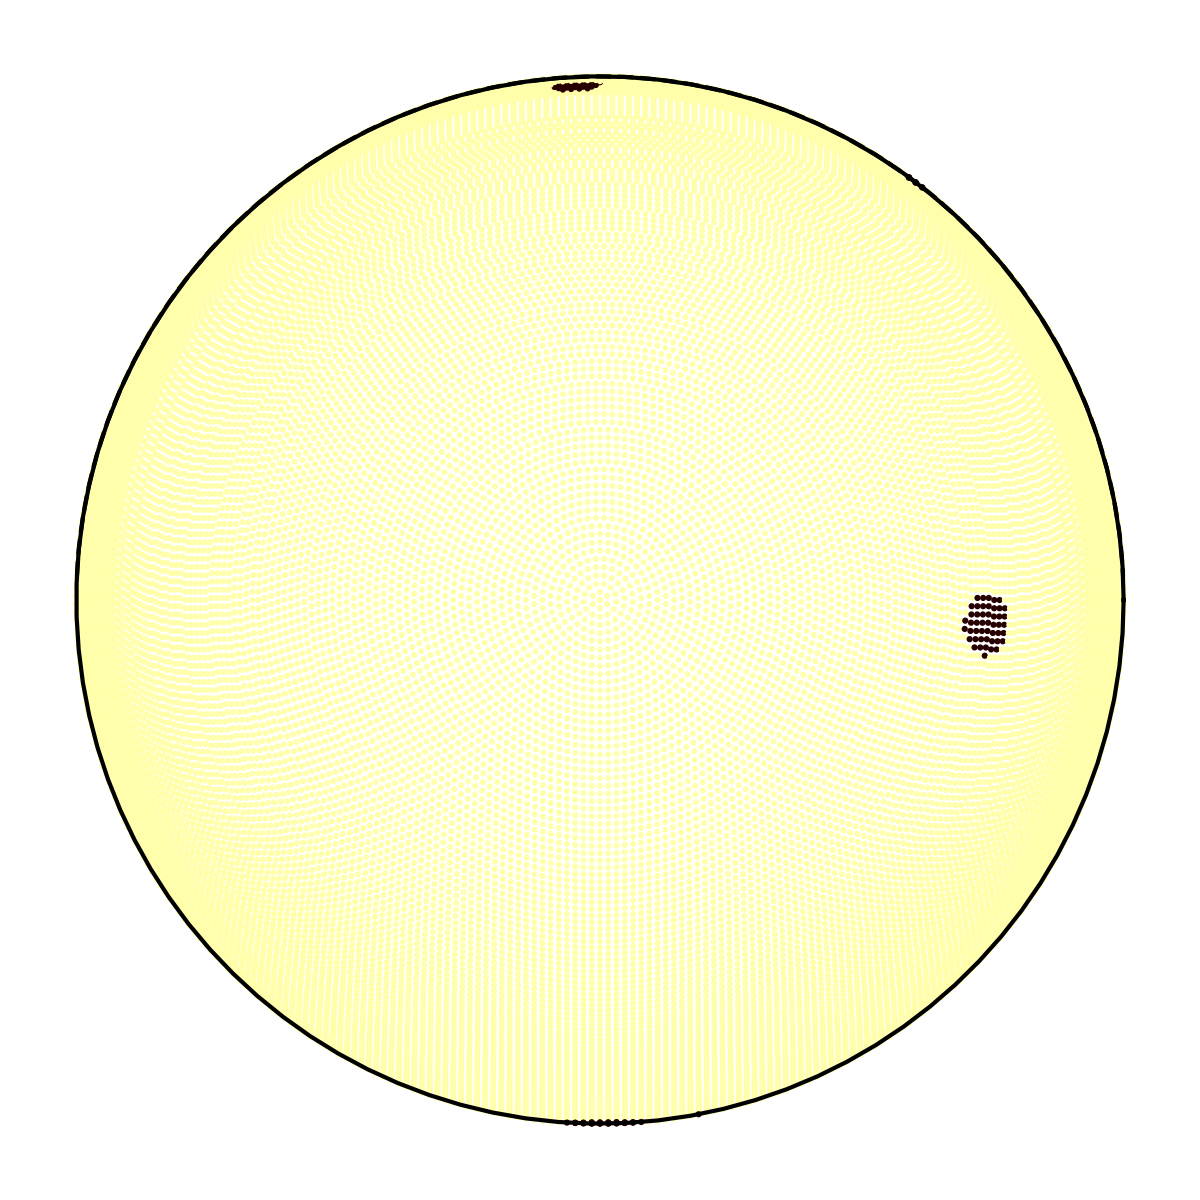

In [15]:
Image(filename='starsim/plots/inversion_spotmap_t_11.0000.png',width=400) 

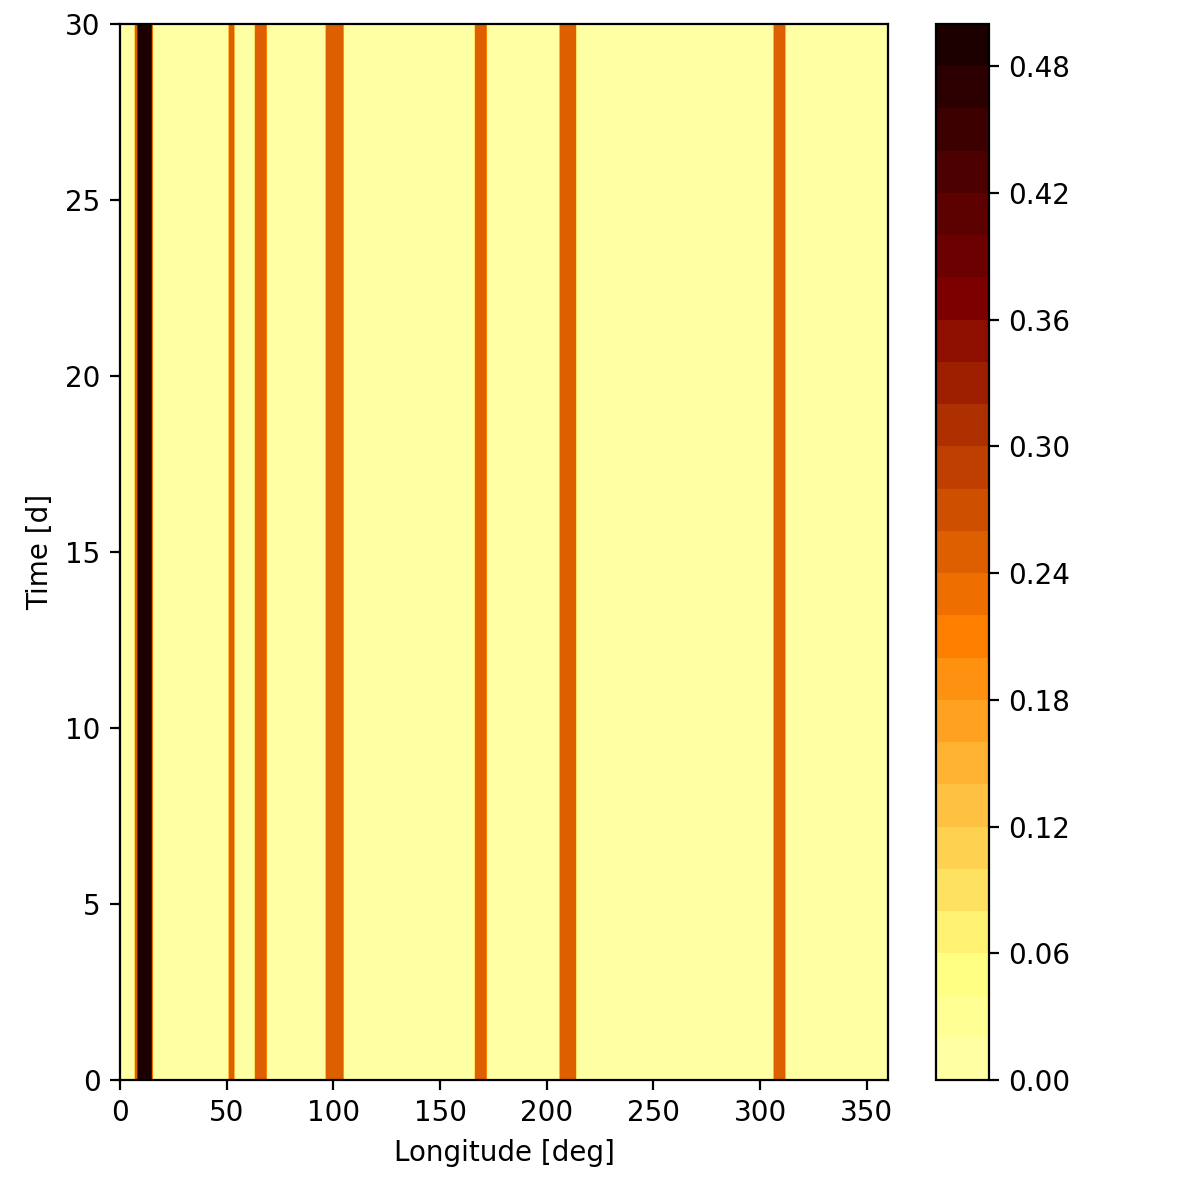

In [16]:
Image(filename='starsim/plots/active_map.png',width=400) 

### 6.3.- Stellar parameter optimization
The stellar parameters of the star can also be optimized by randomly exploring a grid of values and performing an inversion for each of those. This is an expensive routine, that may take several hours depending on the number of iterations you may want. We start by selecting in the configuration file `starsim.conf` the parameters that we want to optimize. Lets optimize the contrast temperature only. You should have something like this at line 88.

#stellar properties  
prior_t_eff_ph :              [0 , 3000 , 6000 , 0 , 4700 , 5500]    # Teff of the star photosphere (K)  
prior_spot_T_contrast :       [1 , 0 , 1000.0 , 0 , 0,500]    # Spot temperature contrast (K)  
prior_facula_T_contrast :     [0 , 0 , 100 , 0 , 0 , 100]    # Facula temperature contrast (K)  
prior_q_ratio :               [0 , 0 , 3 , 0 , 0 , 3]    # Facular to spotted area ratio Q  
prior_convective_blueshift:   [0 , -1 , 1.5 , 0 , -1 , 1.5]    # Convective shift factor.   
prior_p_rot :                 [1 , 9 , 11 , 0 , 9, 11]    # Rotation period (days)  
prior_inclination  :          [0 , 40 , 90, 0 , 40 , 90]    # Inclination of rotation axis (deg, 0 is pole on rotation)  
prior_stellar_radius :        [0 , 0.5, 1.5 , 0 , 0.5 , 1.5]    # Stellar radius (Rsun)  
prior_limb_darkening_q1 :     [0 , 0, 1, 0, 0.3, 0.5] #Limb darkening coefficient q1  
prior_limb_darkening_q2 :     [0 , 0, 1, 0, 0.05, 0.2] #Limb darkening coefficient q2 (don't fit if LD_law is linear)  
#planet  
prior_period_planet:           [0 , 1 , 15 , 0 , 2.77 , 2.78] #period of the planet (days)  
prior_time_transit_planet:	   [0 , 2457400.3 , 2457400.5 , 0 , 2457400 ,2457402.7]  #time of central transit (day)  
prior_semi_amplitude_planet:   [0 , 0 , 2000 , 0 , 120 , 130]  #RV semi-amplitude of panet (m/s)  
prior_esinw_planet:            [0 , -0.7 , 0.7 , 0 , -0.1 , 0.1] #eccentricity times sine of arg. periastron  
prior_ecosw_planet:            [0 , -0.7 , 0.7 , 0 , -0.1 , 0.1]  #eccentricity times cosine of arg. periastron  
prior_radius_planet:           [0 , 0.05 , 0.1 , 0 , 0 , 0.5] #Radius of planet (R*)  
prior_impact_parameter_planet: [0 , 0 , 1 , 0 , 0 , 1] #Impact parameter of the planet. b>1+Rp means no transit.  
prior_spin_orbit_planet:       [0 , 0 , 15 , 0 , 0 , 360]  # Spin-orbit angle of the transit chord (deg)  

Each line corresponds to a different stellar parameter. In brackets, there are 6 numbers: The first one is to optimize it (1) or leave it fixed (0). The second and third are the lower an upper limits where the optimization will be performed. **Make sure that the fixed parameters are within the specified limits, it will not throw an error but infinite log-likelihoods**. The third, fourth and fifth columns are the priors to generate the initial values. In this case we only optimize the spot contrast temperature, with an uniform prior between 0 and 500, and limits between 0 and 1000 (note that since we use an uniform prior there will be no values over 500, the limit is used with none uniform priors).

The last step is to select the number of random evaluations that we starsim will make. This is set with the parameter N_steps in `starsim.conf`. We set a small value of 8 only to sped up the process, but we recommend values larger than 1000 at least.

Before starting the optimization we should restart the ss object to apply the changes in starsim.conf.

In [17]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)


And the optimization is started with:

In [18]:
ss.optimize_inversion_SA()


Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv
Searching random grid for best stellar parameters. Optimizing spotmap at each step.
Total parameters to optimize: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2374.69it/s]


[490.834  10.391] -inf
[97.567 10.709][491.495  10.958]  -inf-inf

[348.848  10.34 ] -inf
[70.462 10.585] -inf
[218.808   9.525] -inf
[283.935   9.028] -inf
[312.809  10.16 ] -inf


Let's now print the results and plot some figures. It only takes solutions within DeltalnL of the best reusult. We recommend ussing DeltalnL<=15, since are comparable fits, but in this tutorial we use 100 since the number of realizations is really small.

ValueError: Axis limits cannot be NaN or Inf

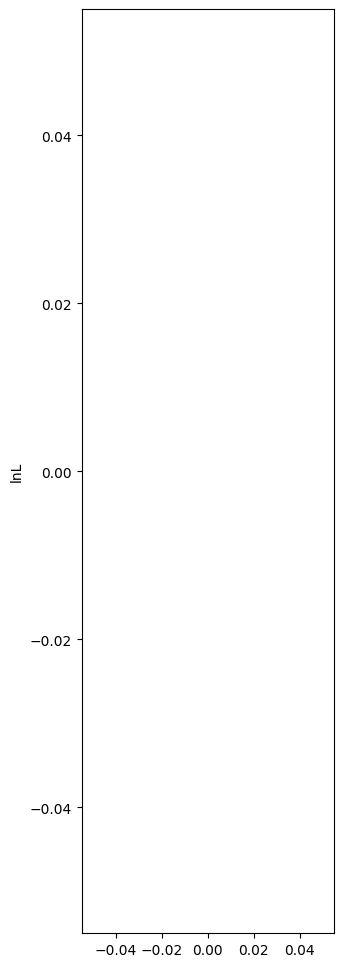

In [19]:
ss.plot_optimize_inversion_SA_results(DeltalnL=100)

In [20]:
Image(filename='starsim/plots/inversion_MCMCSA_likelihoods.png',width=800) 

FileNotFoundError: [Errno 2] No such file or directory: 'starsim/plots/inversion_MCMCSA_likelihoods.png'

This plot the log-likelihoods of each evaluation. As you can see, rotation periods near 10 have the highest likelihoods. However, to obtain significant statistics we should perform much more iterations. The points above the red line are those within DeltalogL, which are selected for the next plots.

In [21]:
Image(filename='starsim/plots/inversion_MCMCSA_cornerplot.png',width=400) 

FileNotFoundError: [Errno 2] No such file or directory: 'starsim/plots/inversion_MCMCSA_cornerplot.png'

With more iterations, the histogram would aproach the input values. Finally, we plot the models of the solutions within DeltalnL.


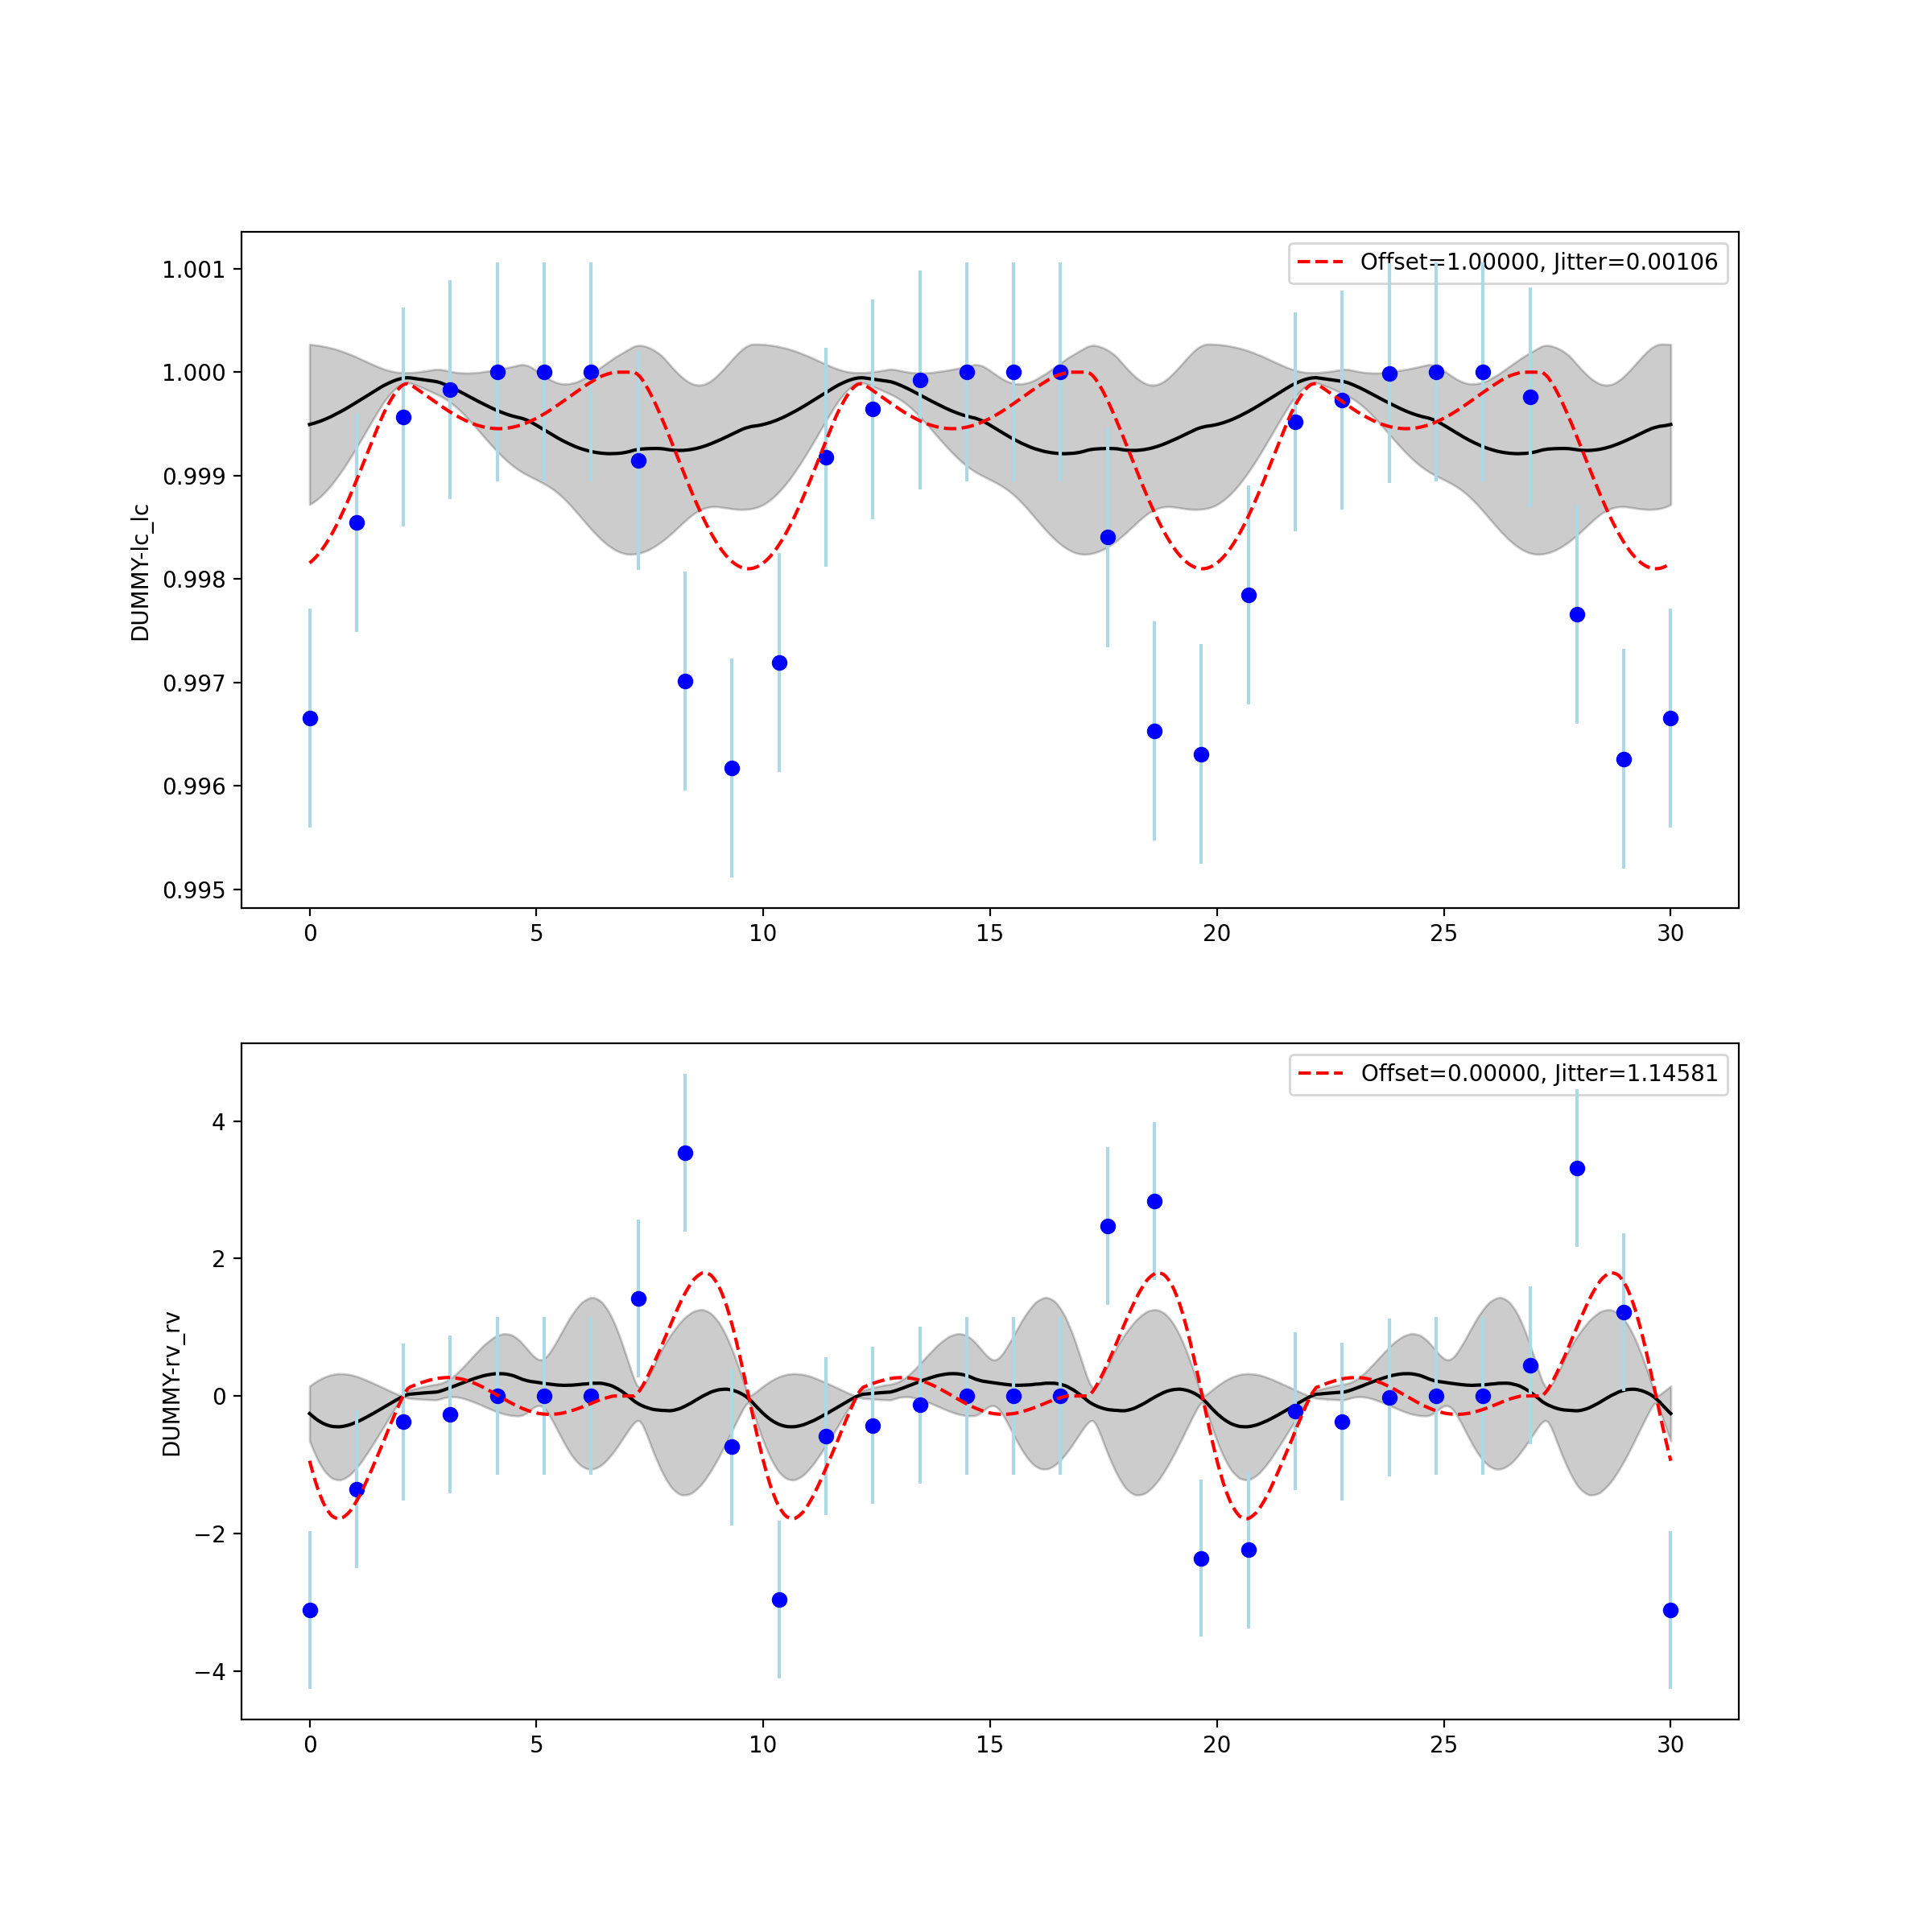

In [22]:
Image(filename='starsim/plots/inversion_timeseries_result.png',width=500) 

If you want to play with the results, they are saved in the file `inversion_MCMCSA_stats.npy`. To acces them simply do:

In [23]:
lnLs, params, best_map = np.load('starsim/results/inversion_MCMCSA_stats.npy',allow_pickle=True)

print('This is the best lnL:',np.max(lnLs))
print('These are the parameters of the best solution',params[np.argmax(lnLs)])
print('This is the best map of the best solution',best_map[np.argmax(lnLs)])

This is the best lnL: -490.7085948212218
These are the parameters of the best solution [5.10000000e+03 1.28619032e+03 3.00000000e+01 0.00000000e+00
 1.45075298e+00 1.15163295e+01 7.04811025e+01 1.04229573e+00
 3.80000000e-01 3.30000000e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
This is the best map of the best solution [[2.45881925e+06 9.99295489e+01 1.74240091e+02 1.90985544e+02
  9.87178530e+00 0.00000000e+00 0.00000000e+00]
 [2.45877754e+06 9.15836602e+01 7.50055585e+01 6.94675106e+00
  1.82315749e+00 0.00000000e+00 0.00000000e+00]
 [2.45880139e+06 2.00272014e+01 1.29580214e+02 2.33163051e+02
  5.27445019e+00 0.00000000e+00 0.00000000e+00]
 [2.45875936e+06 3.87502088e+01 1.91326424e+01 2.13308271e+02
  6.52297318e+00 0.00000000e+00 0.00000000e+00]
 [2.45877241e+06 5.57855501e+01 8.19927268e+01 3.19606418e+02
  1.76824016e+00 0.00000000e+00 0.00000000e+00]
 [2.45876556e+06 9.69740293e+01 6.67397054e+0

### Stellar parameter and spotmap optimization

In some cases when there is only one or two spots, or when the spots are too big for using the fast method (>~20 deg), there is a third option to invert the observed data using either the "fast" or the "precise" modes. This method uses an MCMC chain to simultaneously optimize stellar parameters and spot map. One should specify the number of burn-ins and the number of steps of the chain. Let's optimize now the contrast temperature, the period, and the six parameters of the spot map specified in the spotmap.dat file, with a burn-in length of 100 steps and an additional 100 steps after the burn-in. Once finished, the method will automatically print the results and generate a couple of plots. 


Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv
MCMC uncertainties estimation
Total parameters to optimize: 8
Running first burn-in...
[154.997   9.907  76.624 118.088 201.617 281.59    1.414   3.482] 0.0 84.5045575222041 84.5045575222041
[383.806  10.897  17.824  44.483 258.706  72.477   1.013   2.054] 0.0 93.35897676110383 93.35897676110383
[ 18.506  10.343 166.497 178.684 187.045  93.547   1.883   3.119] 0.0 87.22186259814539 87.22186259814539
[149.806  10.705  90.592 102.092 112.656 237.636   3.585   4.878] 0.0 80.93519568539593 80.93519568539593
[468.537   9.478  95.129   2.275  36.634  21.53    0.021   2.474] 0.0 87.3407366105728 87.3407366105728
[208.687  10.464  74.543 135.639  71.804  29.849   4.976   2.101] 0.0 132.4867035290732 132.4867035290732
[113.043   9.276 177.593  23.038  26.667  23.797   3.333   3.631] 0.0 89.30936278988177 89.30936278988177
[339.952  10.709  78.393  53.969  83.499 138.938   4.494   

  0%|                                                                                                                              | 0/2 [00:00<?, ?it/s]

[406.954  10.938   7.182  34.603 254.999  67.243   0.816   2.127] 0.0 91.79558189203226 91.79558189203226[409.869  10.632  46.48   73.146 119.75  264.248   1.986   4.531]
 0.0 59.22111735182918 59.22111735182918
[449.75    9.504  94.02    9.215  46.519  37.113   0.105   2.535] 0.0 88.00360445689883 88.00360445689883
[ 60.995  10.46  141.934 153.899 162.972 140.174   2.433   3.688] 0.0 87.0378733894828 87.0378733894828
[301.476   9.321  38.442  90.93  193.381 110.526   1.823   4.04 ] 0.0 68.7018898817976 68.7018898817976
[ 36.605   9.743  87.721 176.181  74.822  83.741   2.704   3.745] 0.0 87.44244413553426 87.44244413553426
[305.798  10.569  58.009 168.231 143.75  307.817   2.909   2.116] 0.0 84.05090768995134 84.05090768995134
[316.111  10.558  25.545 124.491 252.574  85.29    1.666   0.531] 0.0 87.64845049686657 87.64845049686657
[150.151  10.737 130.783 156.073 192.472 305.959   1.931   2.529] 0.0 86.94775908461075 86.94775908461075
[217.738  10.159  56.041 121.065 222.258 197.85   

 50%|███████████████████████████████████████████████████████████                                                           | 1/2 [00:05<00:05,  5.96s/it]

[123.415  10.632 105.849 117.487 127.608 208.674   3.243   4.525] 0.0 83.19502503684562 83.19502503684562
[298.589  10.347  50.967  43.526  33.093 164.086   4.19    3.442] 0.0 112.88107210889365 112.88107210889365
[289.03    9.424  64.942 118.366 128.305  60.588   1.305   3.728] 0.0 81.61342765822315 81.61342765822315
[198.909  10.26   82.73  110.792  79.464 113.274   3.661   1.958] 0.0 96.90566059473213 96.90566059473213
[118.659   9.914 155.545  96.221 177.694  83.152   3.276   2.307] 0.0 87.48065195733565 87.48065195733565
[427.535   9.391 126.828 102.228 139.322 125.123   1.789   2.805] 0.0 75.29743595460387 75.29743595460387
[122.573  10.024  79.451 118.021 219.352 335.055   1.441   3.422] 0.0 89.49170334516938 89.49170334516938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.53s/it]


Running second burn-in...
[203.616  10.542  80.805 128.449 116.913  78.738   4.719   1.656] 0.0 83.42868134639811 83.42868134639811
[161.467  10.13   40.918 130.541  11.782  75.041   4.807   1.822] 0.0 109.01966025531677 109.01966025531677
[212.177  10.415  79.395 141.323 105.798  49.305   4.844   1.936] 0.0 84.80072904718887 84.80072904718887
[184.794  10.438  92.029 112.862  90.009  -9.451   4.99    1.607] 0.0 100.05721932807961 100.05721932807961
[137.048  10.524 119.385 113.964  59.222  -4.341   4.866   2.016] 0.0 121.55962852140098 121.55962852140098
[219.345  10.547  71.629 133.663  37.05   65.189   4.463   1.642] 0.0 119.33098536504093 119.33098536504093
[208.382  10.38   66.751 117.648  42.238  -6.084   4.578   2.595] 0.0 138.63934191628795 138.63934191628795
[229.083  10.366  92.342 120.25   75.789  30.848   4.789   2.138] 0.0 118.42392759246496 118.42392759246496
[157.285  10.178  68.59  136.446 107.209  -2.136   4.78    1.933] 0.0 82.37635606633499 82.37635606633499
[206.885

  0%|                                                                                                                              | 0/2 [00:00<?, ?it/s]

[207.475  10.535  82.211 128.686 122.116  85.676   4.669   1.576] 0.0[208.609  10.382  67.509 119.066  46.047  -2.765   4.594   2.555] 79.71928880247577  0.079.71928880247577 146.34639357109765
 146.34639357109765
[225.052  10.415  86.878 126.522  60.355  25.499   4.911   2.146] 0.0 148.13369768461922 148.13369768461922
[164.078  10.113  44.721 131.604  34.734  68.87    4.971   1.901] 0.0 126.71808413259 126.71808413259
[207.07   10.77   49.927 142.626  70.182  19.455   4.841   1.676] 0.0 117.30219607704882 117.30219607704882
[239.32   10.642  97.056 125.533  48.256   8.599   4.749   2.081] 0.0 117.2927561570809 117.2927561570809
[188.438  10.493  85.142 117.731  86.766  -4.722   4.966   1.618] 0.0 107.7821755452272 107.7821755452272
[220.725  10.515  75.318 131.936  42.687  55.589   4.571   1.764] 0.0 129.76012921511736 129.76012921511736


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.17s/it]


Running production...


  0%|                                                                                                                              | 0/8 [00:00<?, ?it/s]

[221.554  10.585  57.85  143.337  75.99   -8.786   4.413   1.788] 0.0 120.44422338995544 120.44422338995544
[230.928  10.179  74.142 148.676  13.048  64.784   4.549   1.472] 0.0 [153.447  10.113  62.354 144.204 132.599  23.694   4.832   1.869] 120.949341405403150.0  120.9493414054031578.80973060335286 
78.80973060335286
[203.686  10.124  21.766 140.223  69.06  118.302   4.883   1.687] 0.0 93.76346718684184 93.76346718684184
[243.975  10.697  84.146 123.153  20.874  20.642   4.144   2.055] 0.0 93.46063810608003 93.46063810608003
[229.791  10.366  68.506 119.247  77.437  43.702   4.529   1.824] 0.0 117.02642689412207 117.02642689412207


 12%|██████████████▊                                                                                                       | 1/8 [00:03<00:23,  3.41s/it]

[203.361   9.963  66.874 153.434   7.274  16.664   4.586   1.636] 0.0 131.81960308122518 131.81960308122518
[230.403  10.168  46.056 130.754  75.251  -7.683   4.099   1.497] 0.0 101.62598223681817 101.62598223681817
[257.223  10.634  81.268 123.613  42.693  18.141   4.46    1.881] 0.0 112.6632300080638 112.6632300080638
[218.085  10.51   60.317  88.44   38.126  27.532   4.754   2.146] 0.0 120.15536374956986 120.15536374956986
[186.083  10.279  44.255 121.886   3.071  27.437   4.623   2.088] 0.0 103.81634740348181 [244.64   10.315  73.666 122.725  36.732  29.927   4.176   2.079]103.81634740348181 
0.0 146.72321473853083 146.72321473853083
[227.043  10.366  98.178 118.168  87.963  10.066   4.751   1.369] 0.0 96.94752535762981 96.94752535762981
[263.33   10.281  87.504 107.027  59.25   -0.305   3.976   1.608] 0.0 146.75454494768655 146.75454494768655
[174.44   10.688 125.507 123.736 150.323  59.83    4.864   1.614] 0.0 82.93257669609976 82.93257669609976
[231.91   10.446  94.613 121.783  

 25%|█████████████████████████████▌                                                                                        | 2/8 [00:08<00:25,  4.24s/it]

[243.379  10.268  58.132 121.216  59.864  17.874   3.913   2.161] 0.0 135.31894736862188 135.31894736862188
[193.181   9.979  70.139 151.36   51.438  30.438   4.673   1.572] 0.0 120.51228601051912 120.51228601051912
[171.652  10.035  32.257 132.164  33.647  48.62    4.497   2.135] 0.0 110.12036931414781 110.12036931414781
[261.269  10.355  73.745  98.787  44.62   77.801   4.439   1.195] 0.0 158.83696574560918 158.83696574560918
[250.682  10.445  62.796 127.554  95.603   5.864   3.745   1.253] 0.0 98.44303865161604 98.44303865161604
[234.483  10.576  42.94  138.97   42.164  58.555   4.813   2.09 ] 0.0 117.84762504592777 117.84762504592777
[249.572  10.219 119.881  99.993  59.773  -3.271   3.734   1.282] 0.0 121.31057341286694 121.31057341286694
[210.407  10.538  84.146 152.862 104.963 113.321   3.725   1.117] 0.0 93.81679583716647 93.81679583716647


 38%|████████████████████████████████████████████▎                                                                         | 3/8 [00:13<00:23,  4.79s/it]

[200.561  10.417  89.154 159.967 152.347 130.298   4.135   1.104] 0.0 74.9548565358666 74.9548565358666
[269.787  10.459 104.424 112.778  85.076  55.465   4.802   1.614] 0.0 101.33748922465733 101.33748922465733
[259.476  10.699 118.071 134.431  80.345  90.408   4.231   1.22 ] 0.0 118.35756412140408 118.35756412140408
[184.446  10.335  50.234 134.96   27.443  81.394   4.606   1.619] 0.0 116.18934519713059 116.18934519713059
[212.76   10.373  55.85   99.983  29.535   3.761   3.783   2.398] 0.0 110.81458365726058 110.81458365726058
[281.365  10.186  81.271  76.626  46.295  42.792   3.918   0.637] 0.0 158.28938064894612 158.28938064894612
[337.157  10.285  95.049  71.434  23.006  26.428   3.463   0.837] 0.0 120.05703202654507 120.05703202654507
[177.234  10.696  56.049 134.468   3.81   26.334   4.937   2.378] 0.0 89.96137566088058 89.96137566088058


 50%|███████████████████████████████████████████████████████████                                                           | 4/8 [00:17<00:18,  4.58s/it]

[204.319  10.175  62.785 128.63   64.61   13.484   4.099   1.953] 0.0 119.59629424518334 119.59629424518334
[212.512  10.328  82.473 126.482  85.347  16.94    4.532   1.846] 0.0 102.60918907903346 102.60918907903346
[188.397  10.388  63.449 142.93   47.976 102.994   4.026   1.336] 0.0 121.44734023517844 121.44734023517844
[183.612  10.295  50.361 139.102  68.956  50.835   4.774   1.99 ] 0.0 117.44463527320104 117.44463527320104
[269.823  10.116  74.048  79.422  74.134  14.816   3.656   0.732] 0.0 99.63541105567757 99.63541105567757
[180.852  10.29   54.282 133.581  83.719 127.749   3.151   1.041] 0.0 93.89657101076429 93.89657101076429
[287.202  10.263  92.31   97.326  14.478  92.23    4.348   1.103] 0.0 113.66803054915802 113.66803054915802


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 7/8 [00:22<00:02,  2.56s/it]

[210.445  10.703  61.859 113.164  40.186  61.999   4.593   2.033] 0.0 113.37614369958882 113.37614369958882
[278.118  10.208  76.541  75.304  17.75   50.468   3.714   0.539] 0.0 119.17635047075237 119.17635047075237
[162.747  10.129 120.518 130.415  28.836   5.191   4.457   1.465] 0.0 128.0897398897558 128.0897398897558
[270.948  10.585  98.8   140.683  29.432  23.174   4.547   2.057] 0.0 101.35688835841873 101.35688835841873
[207.693  10.27   92.491 115.979  43.157 145.198   4.221   1.242] 0.0 146.1436572778662 146.1436572778662
[188.164  10.178  61.526 111.881  -6.233  47.837   4.919   2.301] 0.0 107.03072601701336 107.03072601701336
[203.068  10.388  98.078 122.508  64.178  94.085   4.938   1.647] 0.0 132.66037424900009 132.66037424900009
[195.607   9.817  77.092 143.94    7.553  69.981   4.377   1.326] 0.0 144.56367584297922 144.56367584297922
[200.227  10.49   62.488 145.514 112.826 132.361   2.944   0.721][152.666  10.238 102.117 140.397  67.251  20.21    4.819   1.761]  0.00.0  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:27<00:00,  3.40s/it]


Results of the inversion process:
	 -Mean and 1 sigma confidence interval:
	 	 T$_{{eff}}$  =  3500.0 (fixed) 
	 	 $\Delta$ T$_{{sp}}$ = 203.61588+28.07300-43.44680
	 	 $\Delta$ T$_{{fc}}$  =  30.0 (fixed) 
	 	 Fac-spot ratio  =  0.0 (fixed) 
	 	 CS  =  0.0 (fixed) 
	 	 P$_{{rot}}$ = 10.44575+0.09553-0.26759
	 	 inc  =  90.0 (fixed) 
	 	 R$_*$  =  0.5 (fixed) 
	 	 q$_1$  =  0.43 (fixed) 
	 	 q$_2$  =  0.122 (fixed) 
	 	 P$_{{pl}}$  =  0.932 (fixed) 
	 	 T$_{{0,pl}}$  =  2.0 (fixed) 
	 	 K$_{{pl}}$  =  1.0 (fixed) 
	 	 esinw  =  0.0 (fixed) 
	 	 ecosw  =  0.0 (fixed) 
	 	 R$_{{pl}}$  =  0.07 (fixed) 
	 	 b  =  0.0 (fixed) 
	 	 $\lambda$  =  0.0 (fixed) 
	 	 spot_0_it  =  0.0 (fixed) 
	 	 spot_1_it  =  0.0 (fixed) 
	 	 spot_0_lt  =  40.0 (fixed) 
	 	 spot_1_lt  =  40.0 (fixed) 
	 	 spot_0_lat = 73.66624+15.67504-15.81610
	 	 spot_1_lat = 128.44910+24.98536-14.48474
	 	 spot_0_lon = 60.35468+26.41120-23.62276
	 	 spot_1_lon = 26.46797+35.69089-29.00139
	 	 spot_0_c1 = 4.86635+0.44594-0.61

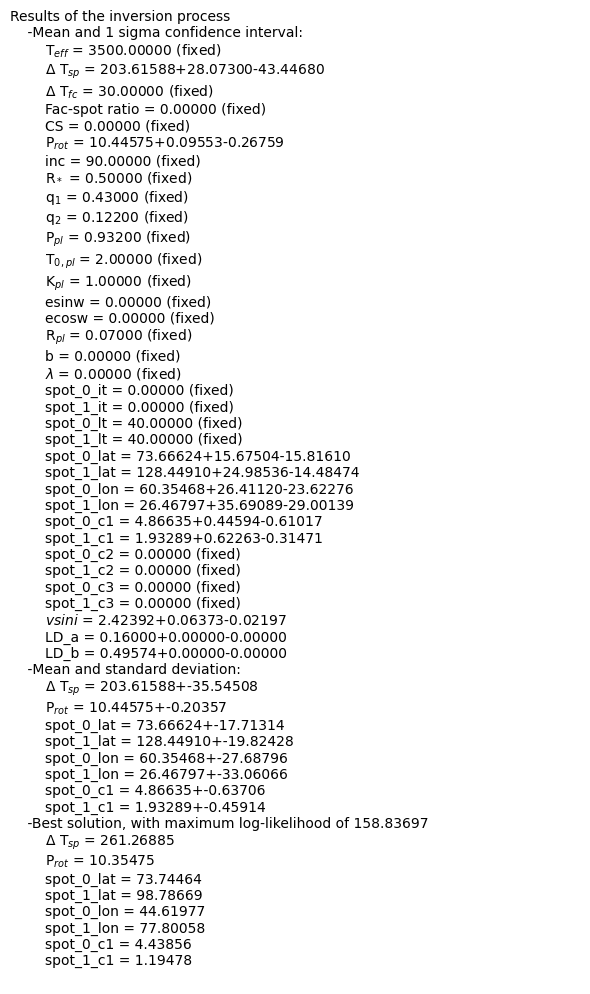

In [24]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)

ss.optimize_MCMC()

In [25]:
ss.plot_MCMCoptimization_chain()
ss.plot_MCMCoptimization_likelihoods()
ss.plot_MCMCoptimization_corner()
ss.plot_MCMCoptimization_best_results(t=np.linspace(t_sampling[0],t_sampling[-1],200),fold=False)
#ss.plot_MCMCoptimization_results(t=np.linspace(t_sampling[0],t_sampling[-1],200))


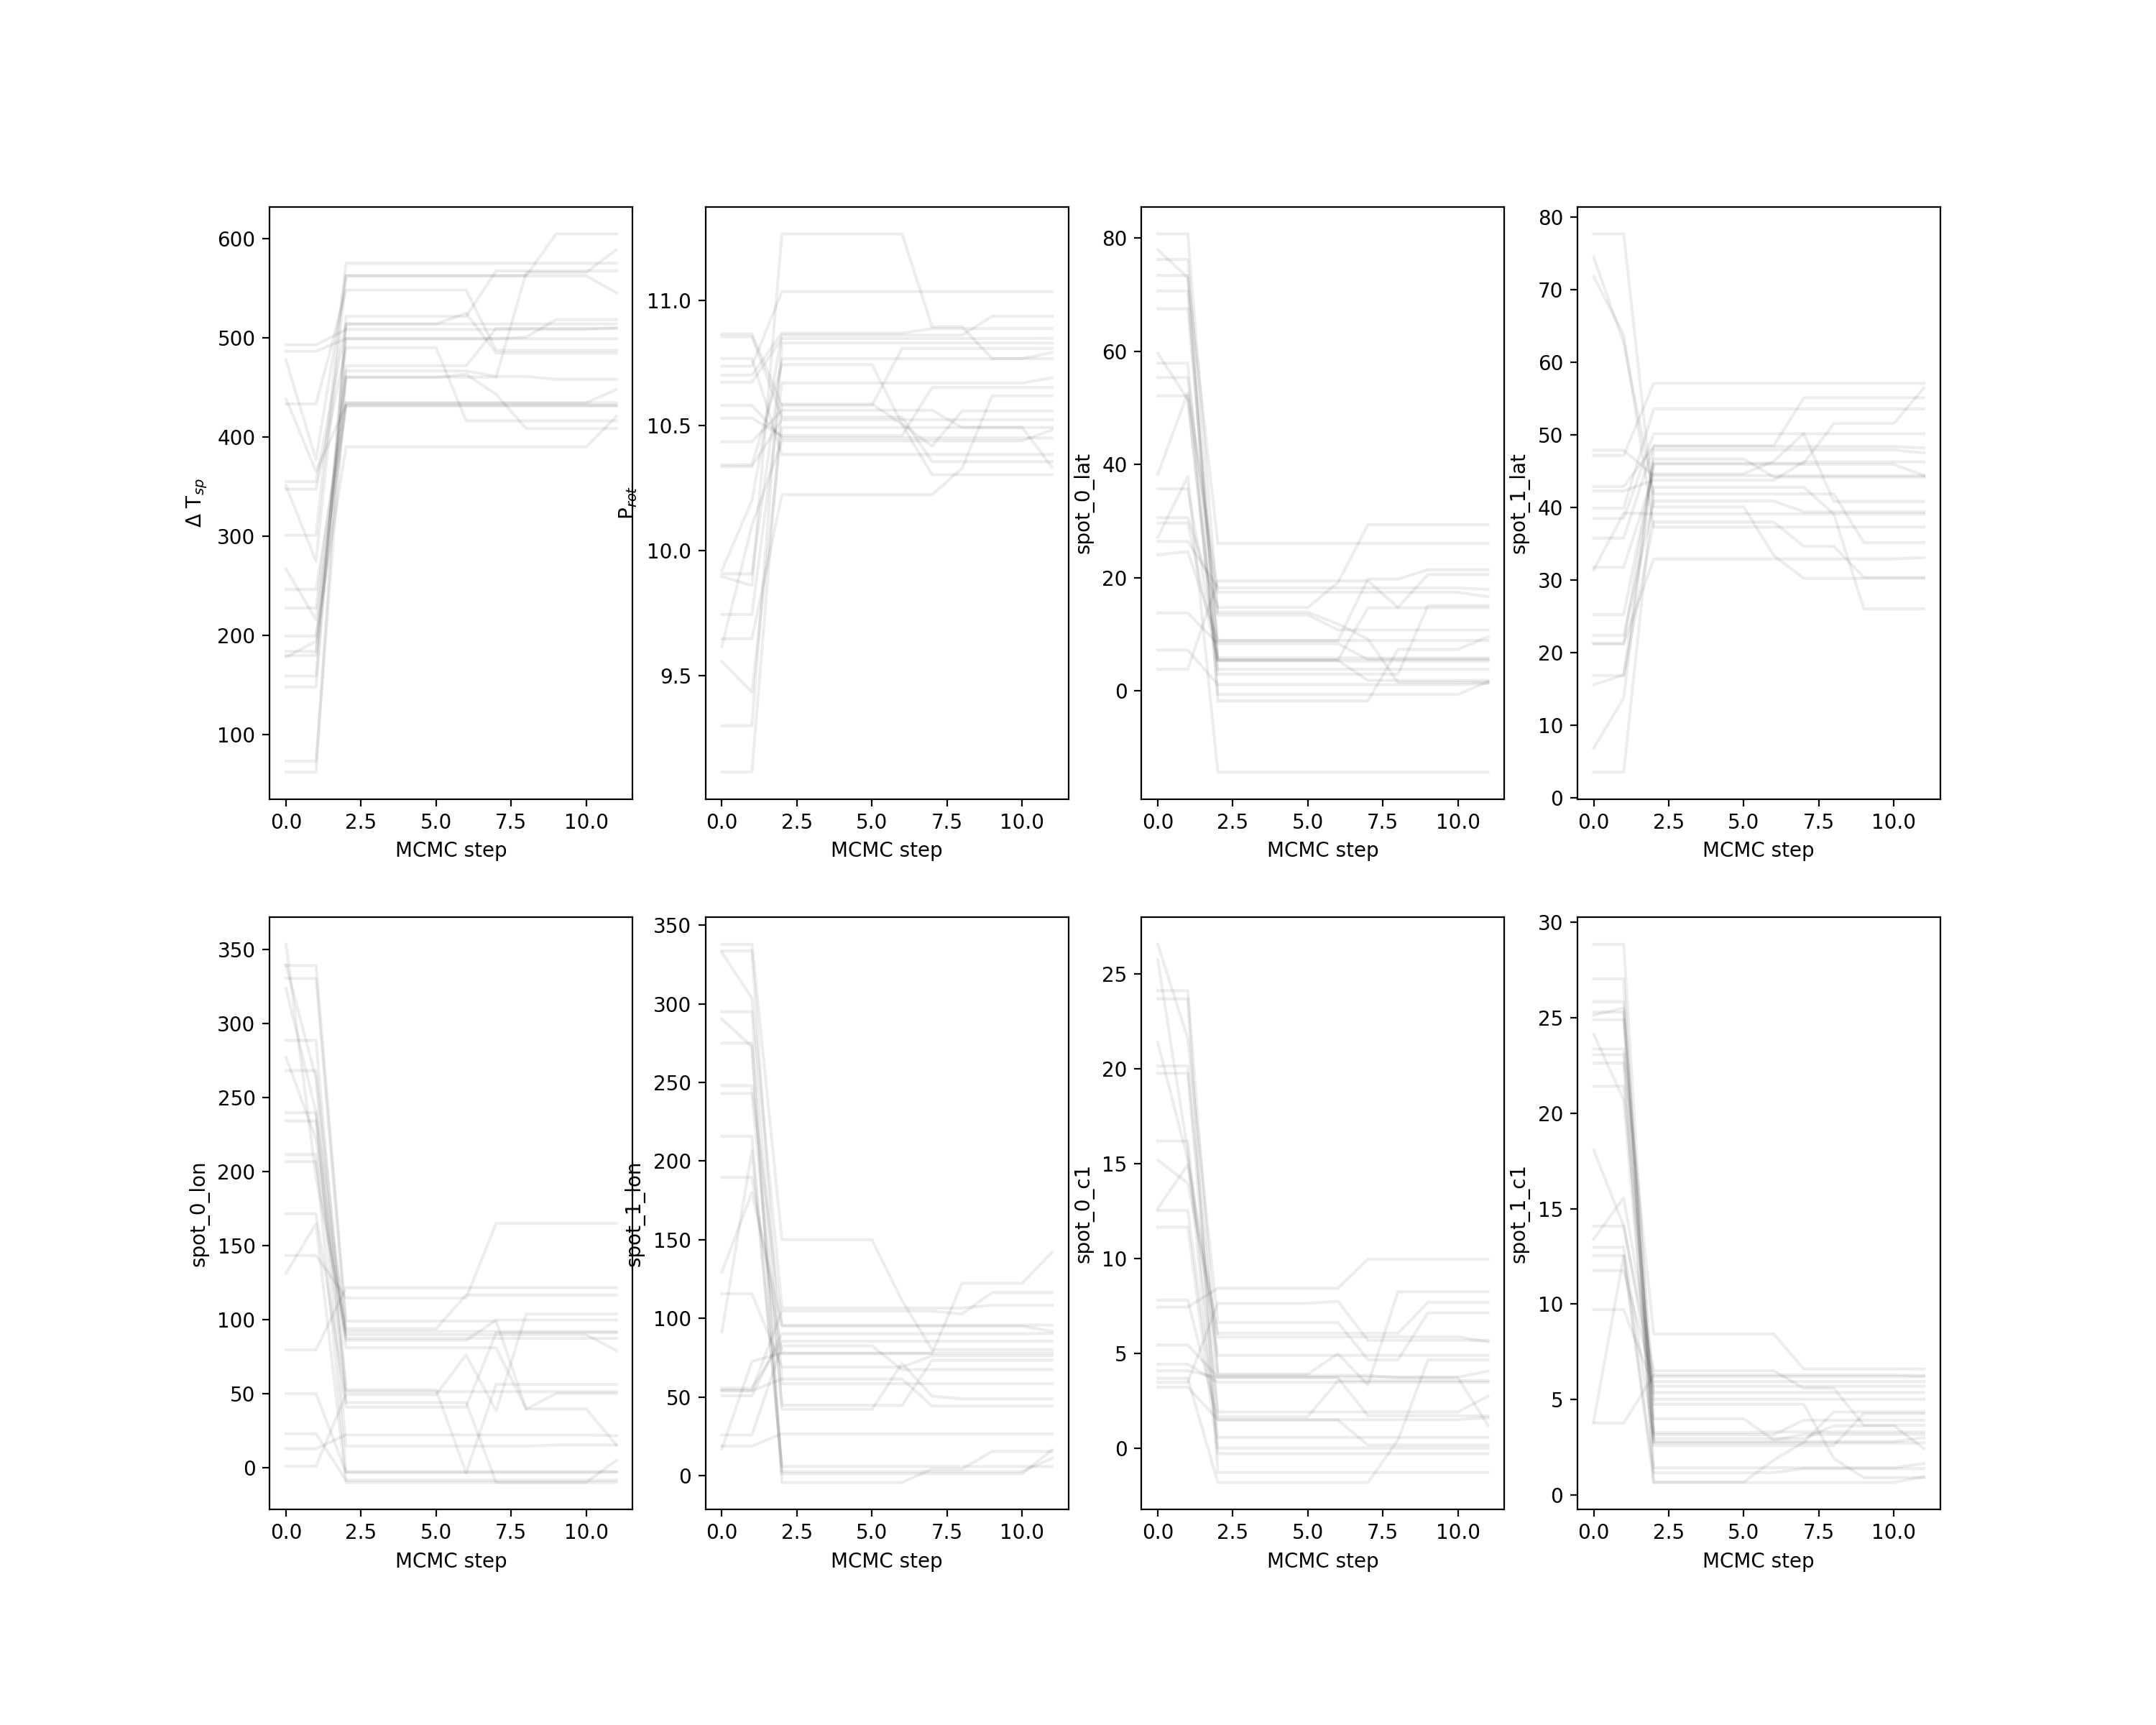

In [26]:
Image(filename='starsim/plots/MCMCoptimization_chains.png',width=800) 

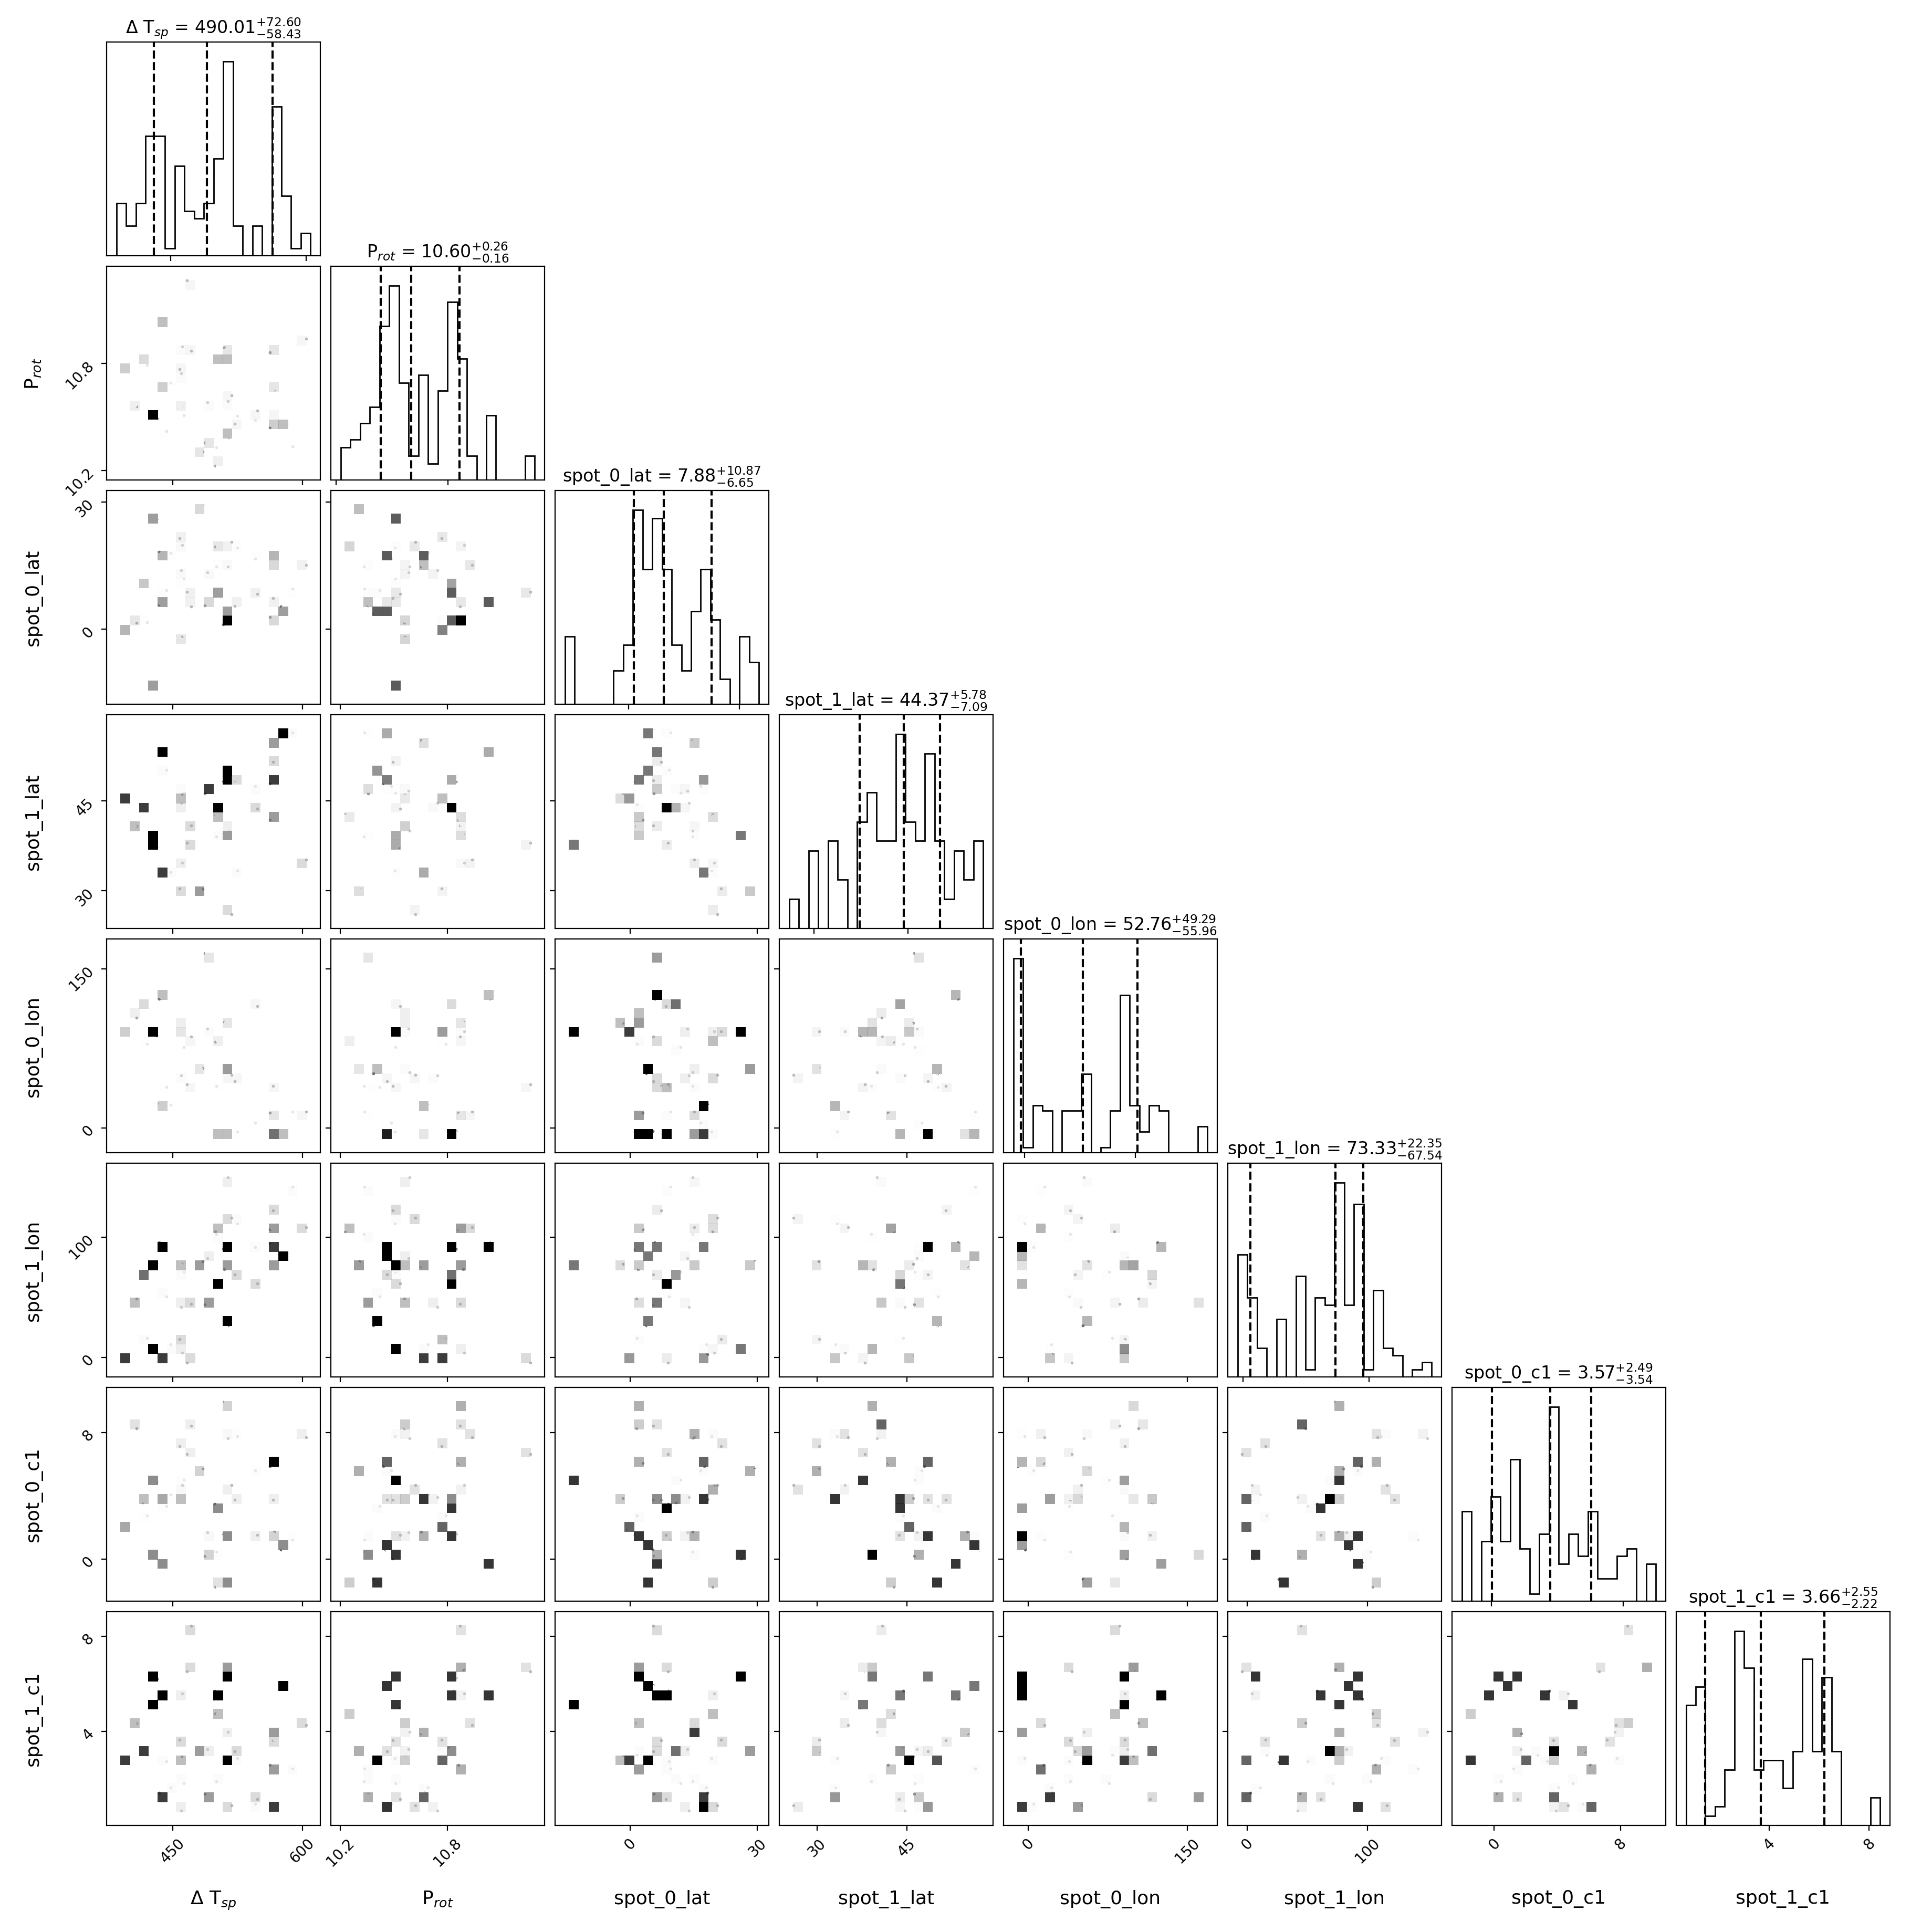

In [27]:
Image(filename='starsim/plots/MCMCoptimization_cornerplot.png',width=500) 

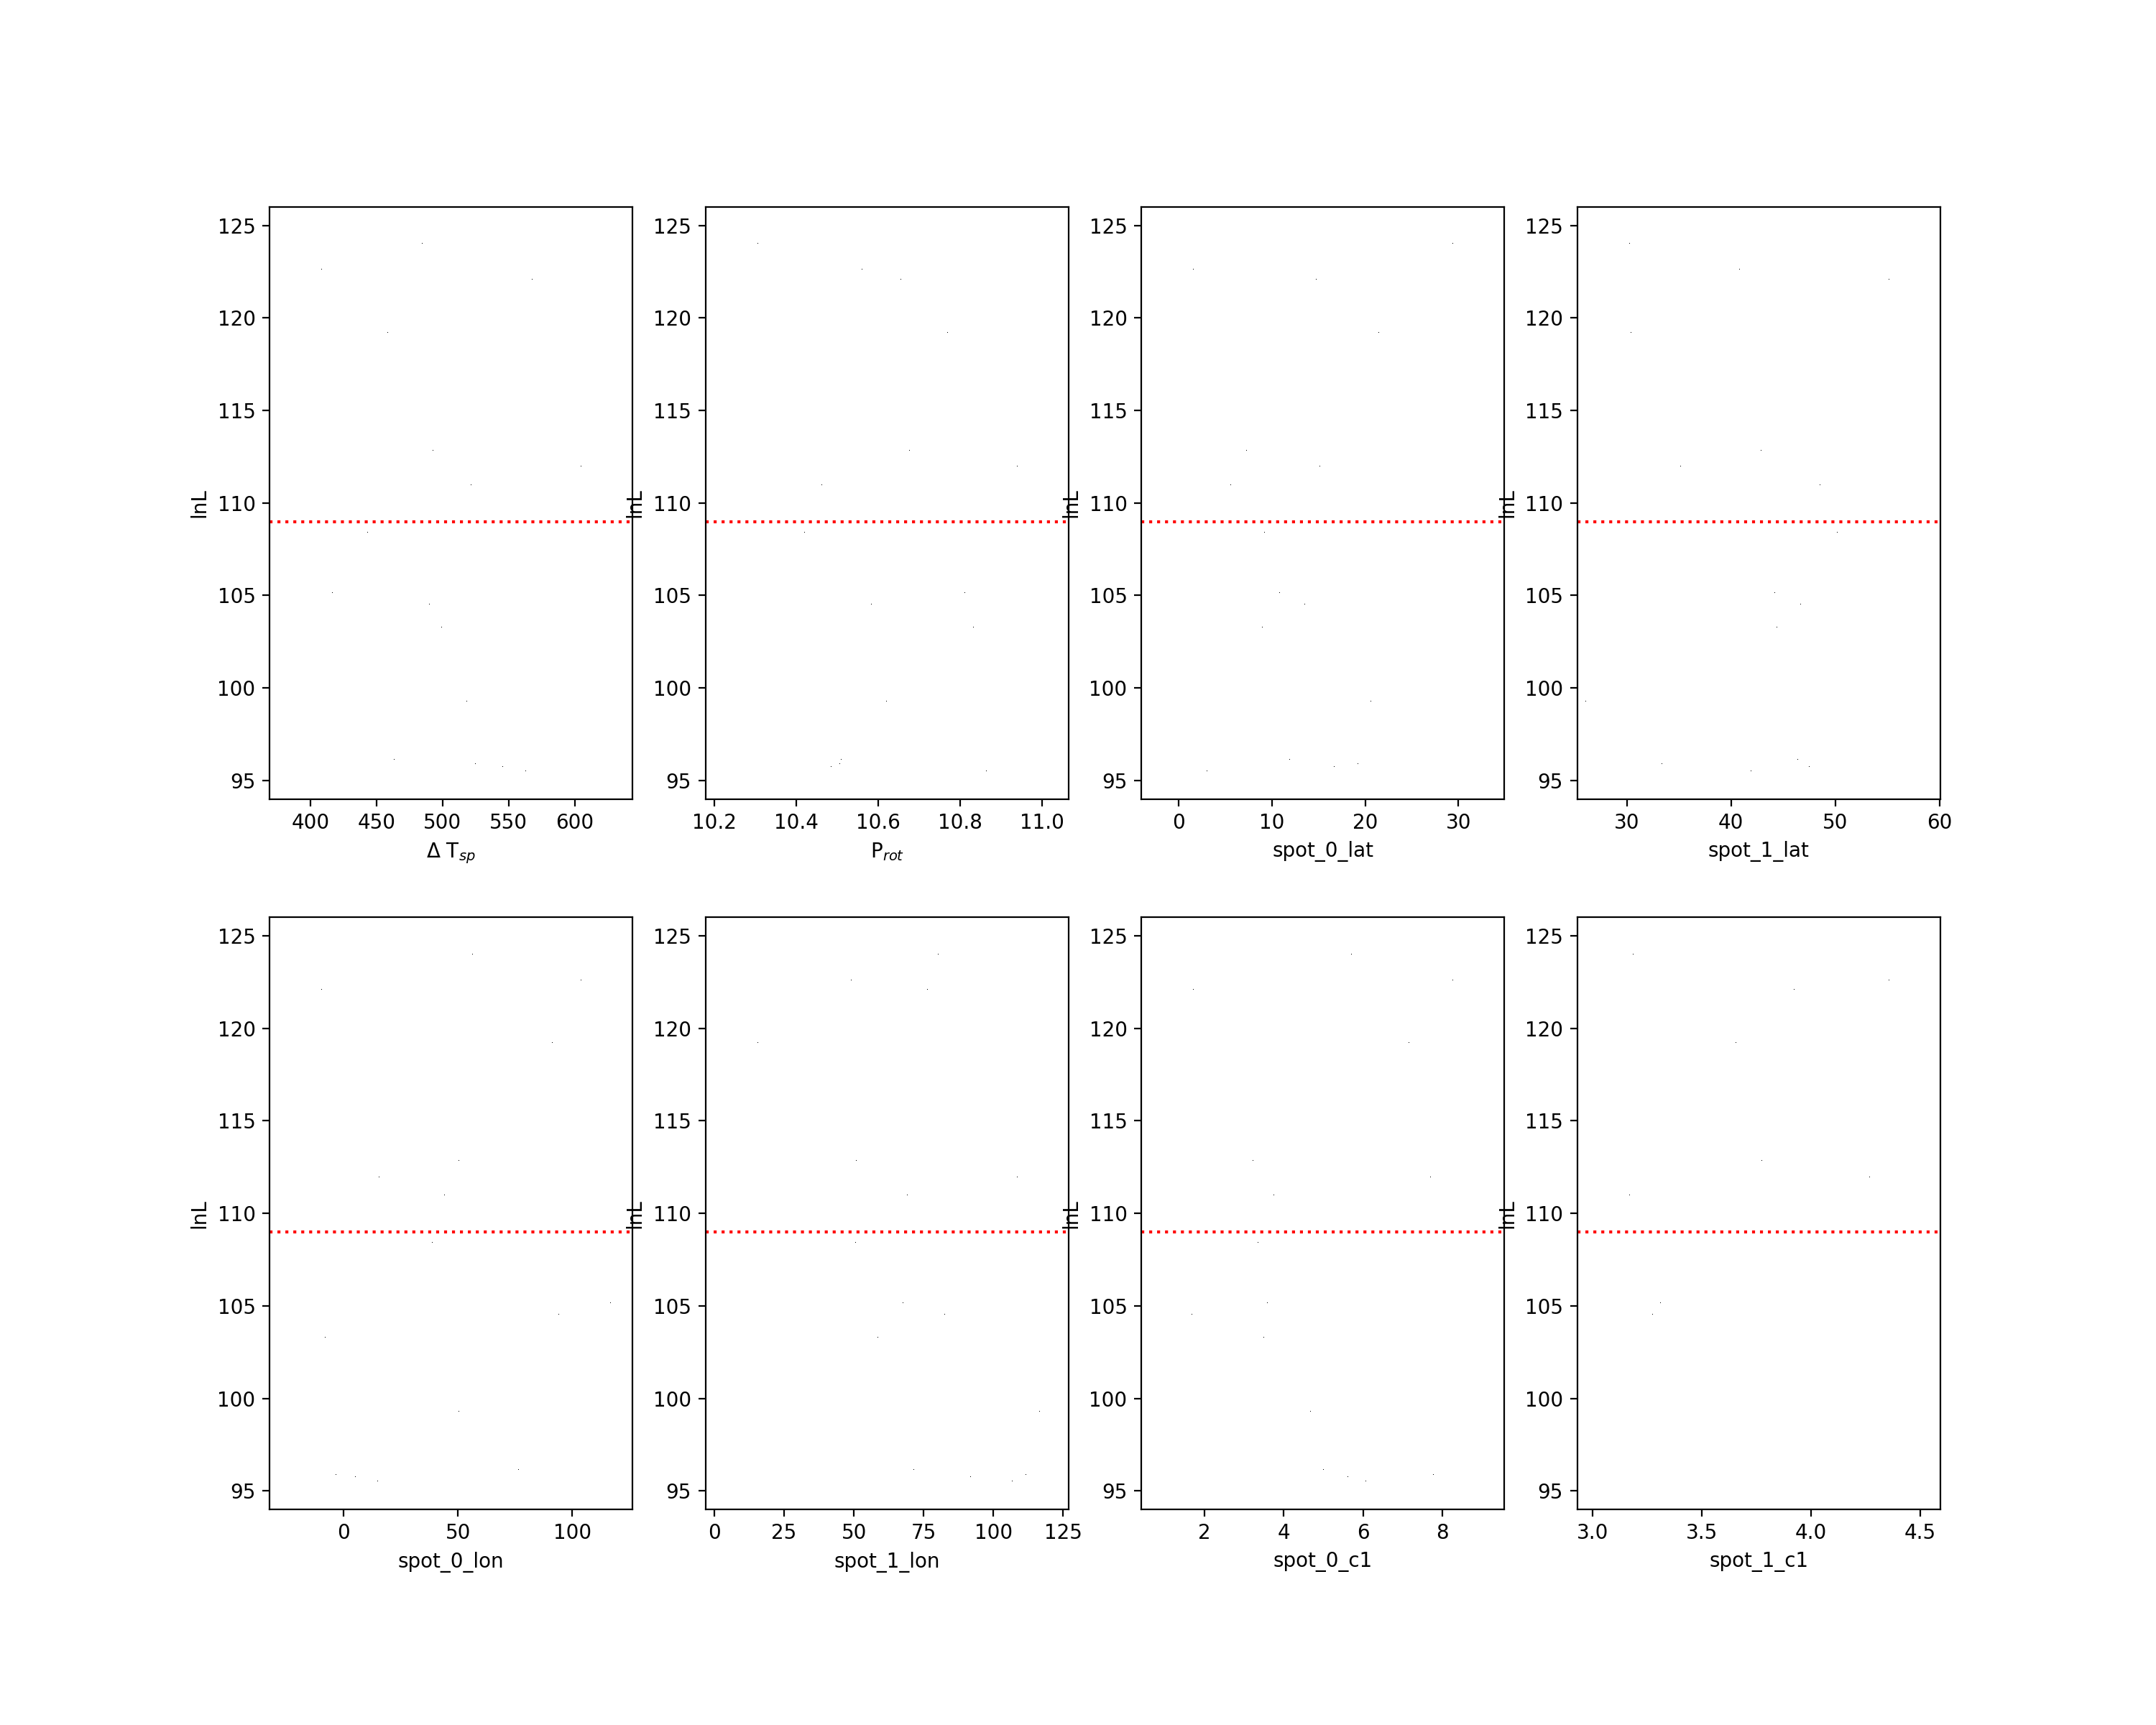

In [28]:
Image(filename='starsim/plots/MCMCoptimization_likelihoods.png',width=600) 

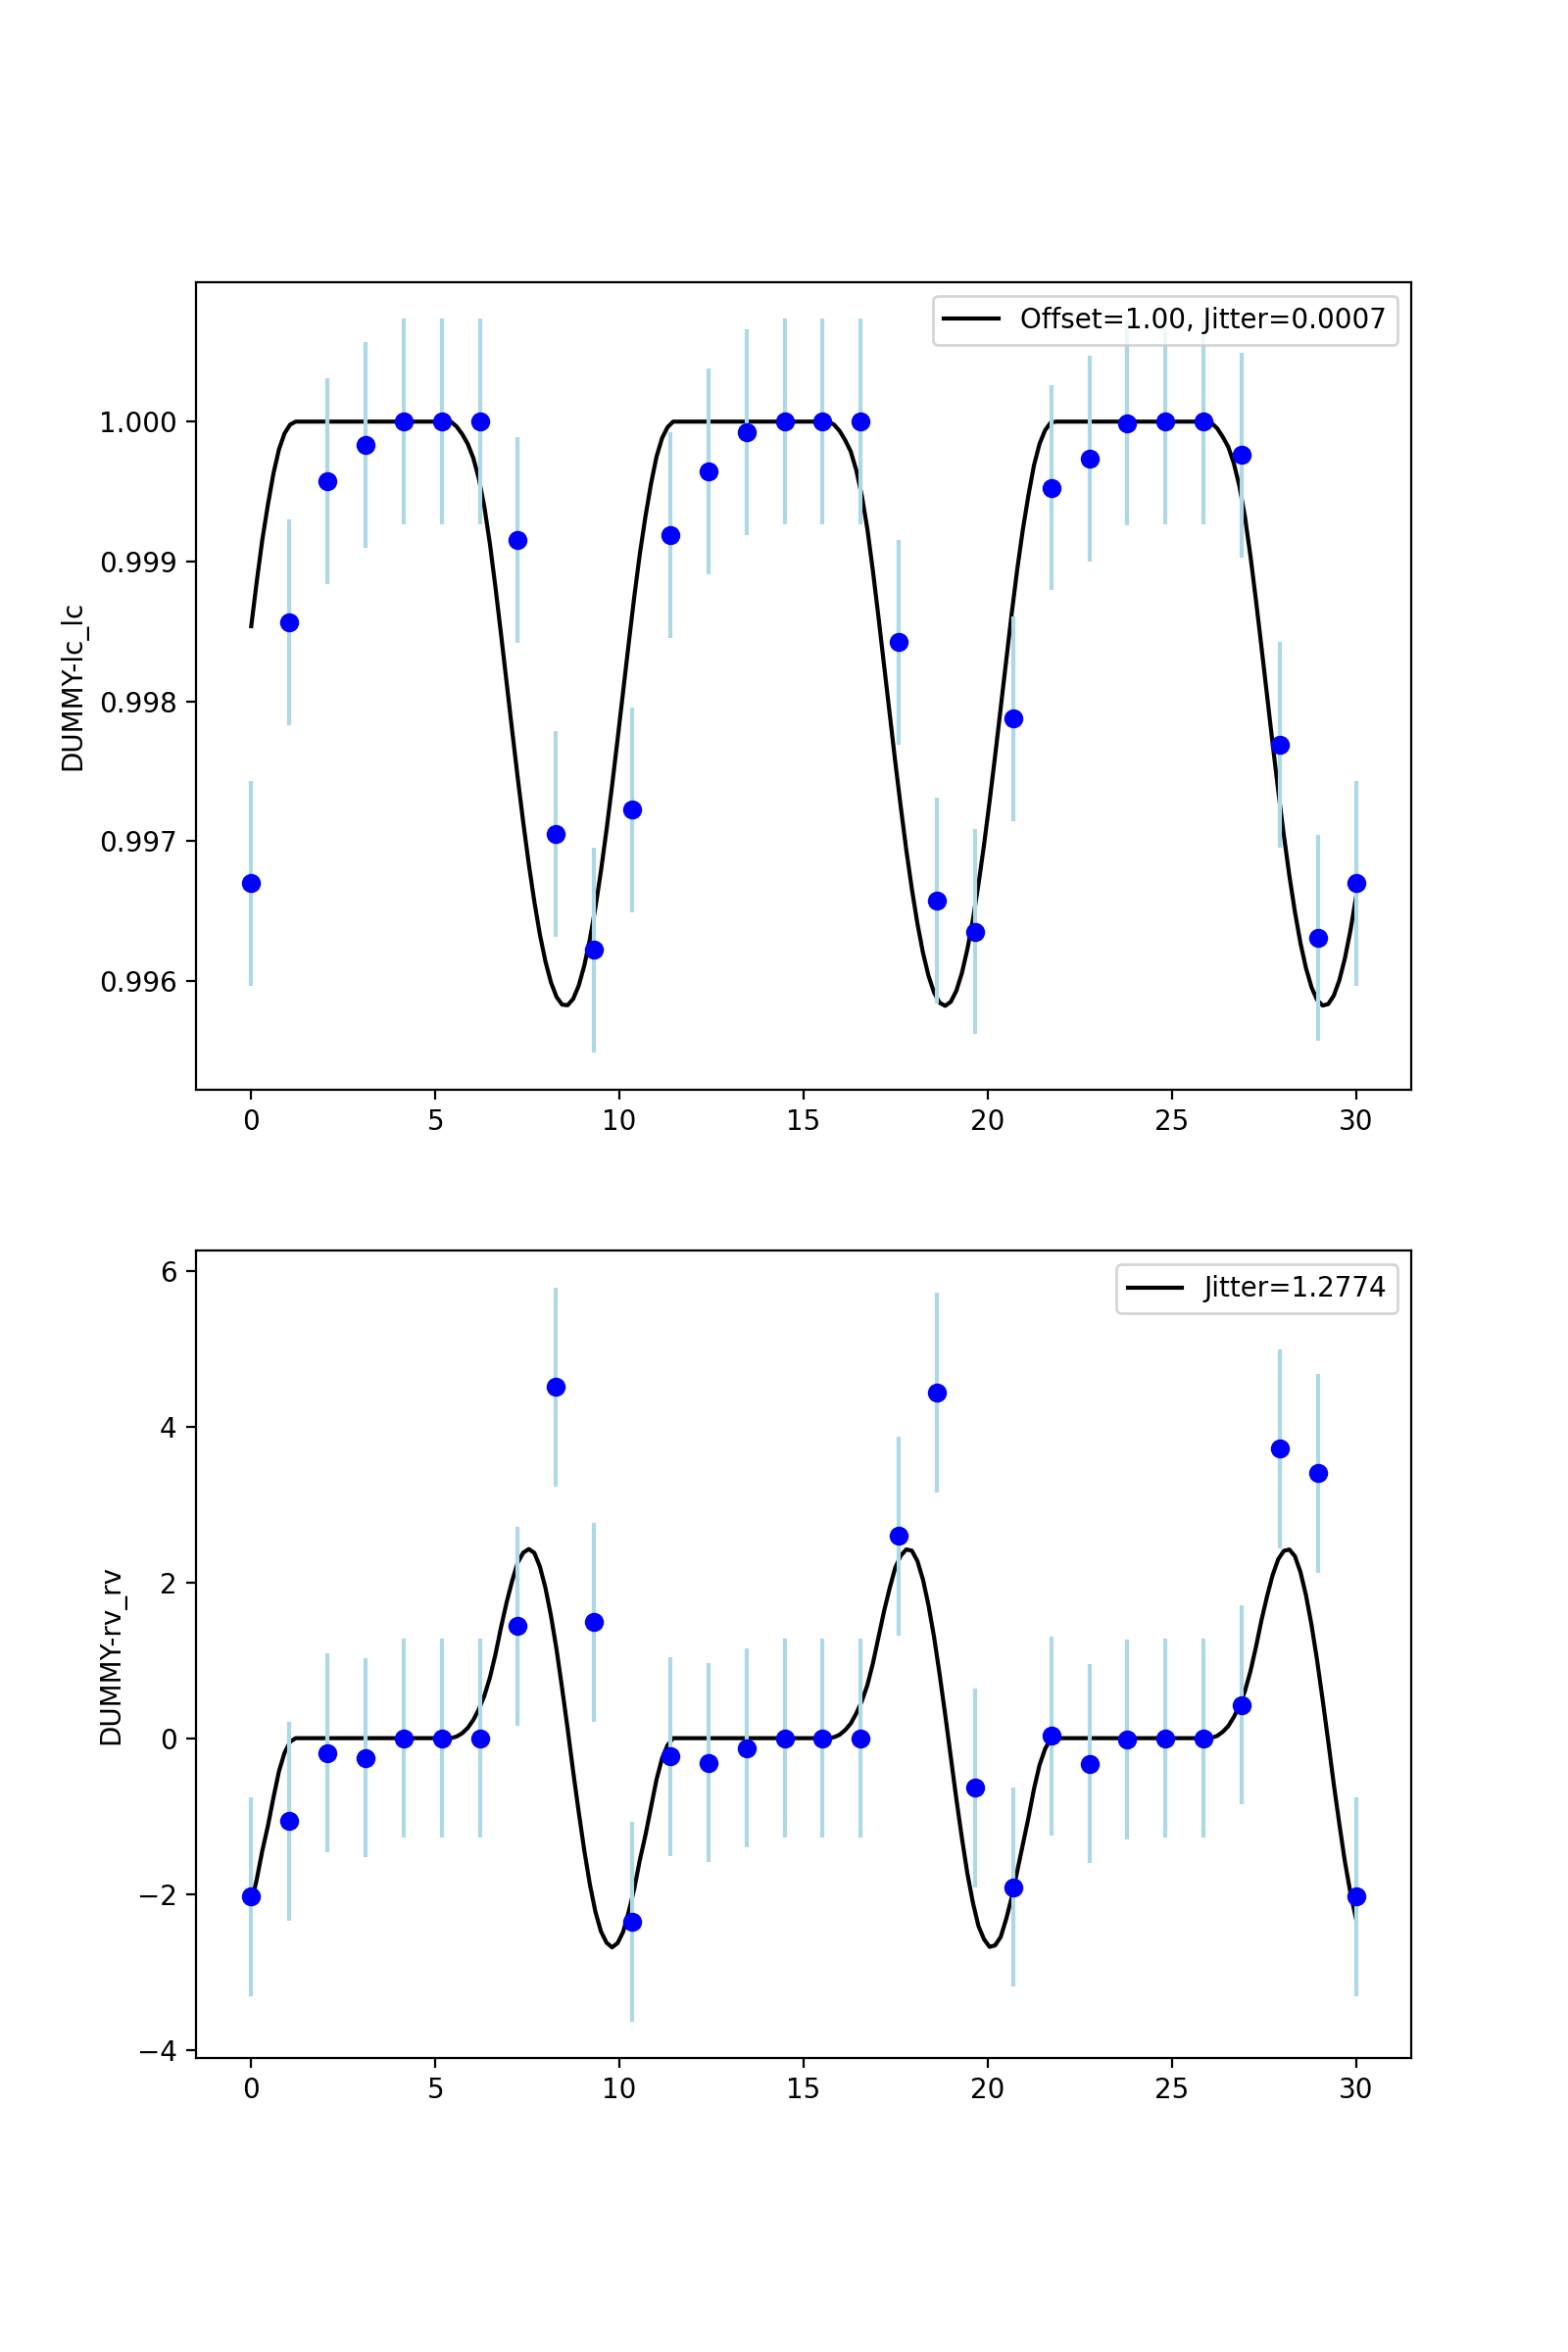

In [29]:

Image(filename='starsim/plots/MCMCoptimization_timeseries_best_result.png',width=300)